In [1]:
#Import Necessary Libraries
import pandas as pd
import numpy as np
import nltk
import textstat
#nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from textstat.textstat import textstat
from matplotlib.table import Table
from scipy.stats import multivariate_normal, invwishart
from abc import ABC, abstractmethod
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
%matplotlib inline

In [2]:
df = pd.read_csv('main_dataset.csv')
test_df = pd.read_csv('exp_test.csv')

In [3]:
df

,index,author,text,ai_label
0,1,John Nery,The success of the Marcos-Duterte electoral al...,0
1,2,John Nery,The war on Ninoy Aquino’s legacy is a fight th...,0
2,3,John Nery,One of many lessons from the ongoing Twitter f...,0
3,4,John Nery,Of course we all need to be particular about t...,0
4,5,John Nery,"In 'Some People Need Killing,' the acclaimed j...",0
...,...,...,...,...
95,96,Copilot,The concept of federalism has been a recurring...,1
96,97,Copilot,Election campaign finance transparency is a co...,1
97,98,Copilot,Mental health stigma remains a significant bar...,1
98,99,Copilot,Urban congestion and housing shortages are two...,1


In [4]:
def preprocess_text(text):
    # Convert to lowercase
    return text.lower()

# Helper function to calculate complex sentence ratio
def count_clauses(sentence):
    # A simple approximation using commas, semicolons, and conjunctions
    return sentence.count(',') + sentence.count(';') + sentence.lower().count('and') + sentence.lower().count('but')

# Feature extraction function
def extract_features(text):
    # Tokenize words and sentences
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    # Basic metrics
    word_count = len([word for word in words if word.isalpha()])
    avg_word_length = np.mean([len(word) for word in words if word.isalpha()]) if word_count > 0 else 0
    avg_sentence_length = word_count / len(sentences) if len(sentences) > 0 else 0

    # Punctuation metrics
    punctuation_count = sum(1 for char in text if char in ['.', ',', ':', ';', '?', '!', '-', '\'', '\"'])
    punctuation_ratio = punctuation_count / word_count if word_count > 0 else 0
    avg_punctuation_per_sentence = punctuation_count / len(sentences) if len(sentences) > 0 else 0

    # Linguistic diversity features
    vocab_size = len(set([word for word in words if word.isalpha()]))
    vocab_ratio = vocab_size / word_count if word_count > 0 else 0

    # Readability metrics
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    gunning_fog = textstat.gunning_fog(text)
    smog_index = textstat.smog_index(text)
    cl_index = textstat.coleman_liau_index(text)

    # Sentence complexity metrics
    total_clauses = sum(count_clauses(sentence) for sentence in sentences)
    avg_clauses_per_sentence = total_clauses / len(sentences) if len(sentences) > 0 else 0
    complex_sentence_ratio = sum(1 for sentence in sentences if count_clauses(sentence) > 1) / len(sentences) if len(sentences) > 0 else 0

    # Lexical density
    pos_tags = pos_tag(words)
    content_words = [word for word, pos in pos_tags if pos.startswith(('NN', 'VB', 'JJ', 'RB'))]
    lexical_density = len(content_words) / word_count if word_count > 0 else 0

    return {
        'word_count': word_count,
        'sentence_count': len(sentences),
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length,
        'punctuation_count': punctuation_count,
        'punctuation_ratio': punctuation_ratio,
        'avg_punctuation_per_sentence': avg_punctuation_per_sentence,
        'vocab_size': vocab_size,
        'vocab_ratio': vocab_ratio,
        'flesch_reading_ease': flesch_reading_ease,
        'gunning_fog': gunning_fog,
        'smog_index': smog_index,
        'coleman_liau_index': cl_index,
        'avg_clauses_per_sentence': avg_clauses_per_sentence,
        'complex_sentence_ratio': complex_sentence_ratio,
        'lexical_density': lexical_density
    }

# Apply preprocessing and feature extraction to each text sample
def preprocess_and_extract_features(df):
    df['preprocessed_text'] = df['text'].apply(preprocess_text)
    df_features = df.apply(lambda row: extract_features(row['preprocessed_text']), axis=1).apply(pd.Series)
    return pd.concat([df[['index', 'label']], df_features], axis=1)

In [5]:
#Apply preprocessing and feature extraction to each text sample
df['preprocessed_text'] = df['text'].apply(preprocess_text)
df_features = df.apply(lambda row: extract_features(row['preprocessed_text']), axis=1).apply(pd.Series)
df = pd.concat([df, df_features], axis=1)

In [6]:
# Define features (X) and target (y)
X = df[['word_count', 'avg_word_length', 'avg_sentence_length',
        'punctuation_ratio', 'avg_punctuation_per_sentence', 'vocab_size', 'vocab_ratio', 
        'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
        'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']]
y = df['author']

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Set up k-fold cross-validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Track metrics across folds
accuracies = []
classification_reports = []

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
    # Split the dataset into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    # Collect classification report for the fold
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports.append(report)
    
    # Print fold-specific metrics
    print(f"Fold {fold} Accuracy: {accuracy:.2f}")
    print(f"Fold {fold} Classification Report:")
    print(classification_report(y_test, y_pred))

# Calculate overall metrics
mean_accuracy = np.mean(accuracies)
print(f"\nOverall Cross-Validation Accuracy: {mean_accuracy:.2f}")


C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

Fold 1 Accuracy: 0.80
Fold 1 Classification Report:
                     precision    recall  f1-score   support

            Copilot       1.00      1.00      1.00         1
 Diwa C. Guinigundo       0.80      1.00      0.89         4
         GPT4o-mini       0.00      0.00      0.00         0
    Gemini1.5-flash       1.00      0.50      0.67         2
      Iris Gonzales       0.67      0.67      0.67         3
          John Nery       0.67      1.00      0.80         2
Jose Ma Montelibano       1.00      0.50      0.67         2
           Llama3.2       1.00      1.00      1.00         4
     Maria A. Ressa       0.00      0.00      0.00         1
      Phind Instant       1.00      1.00      1.00         1

           accuracy                           0.80        20
          macro avg       0.71      0.67      0.67        20
       weighted avg       0.83      0.80      0.79        20

Fold 2 Accuracy: 0.60
Fold 2 Classification Report:
                     precision    recal

C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Fold 3 Accuracy: 0.70
Fold 3 Classification Report:
                     precision    recall  f1-score   support

            Copilot       0.50      1.00      0.67         1
 Diwa C. Guinigundo       0.67      0.67      0.67         3
         GPT4o-mini       0.50      0.50      0.50         2
    Gemini1.5-flash       1.00      1.00      1.00         2
      Iris Gonzales       1.00      0.67      0.80         3
          John Nery       0.75      0.75      0.75         4
Jose Ma Montelibano       0.33      1.00      0.50         1
           Llama3.2       0.00      0.00      0.00         1
     Maria A. Ressa       1.00      0.67      0.80         3

           accuracy                           0.70        20
          macro avg       0.64      0.69      0.63        20
       weighted avg       0.74      0.70      0.70        20

Fold 4 Accuracy: 0.70
Fold 4 Classification Report:
                     precision    recall  f1-score   support

            Copilot       1.00      0.

C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [7]:
# Model Preparation
X_test = test_df.drop(['index', 'label'], axis=1)
y_test = test_df['label']

In [8]:
def classify_new_text(new_text, model):
    # Preprocess the text and extract features
    preprocessed_text = preprocess_text(new_text)
    new_features = extract_features(preprocessed_text)
    new_features_df = pd.DataFrame([new_features])

    # Reindex using the cleaned X_train's columns
    new_features_df = new_features_df.reindex(columns=X_train.columns)

    # Handle any NaN values
    new_features_df = new_features_df.fillna(0)

    # Predict the author
    predicted_author = model.predict(new_features_df)
    return predicted_author[0]

In [9]:
# Function to extract features and store them into a DataFrame
def extract_features_as_df(text):
    # Call the existing extract_features function
    raw_features = extract_features(text)
    
    # Convert the features to a DataFrame with two columns: Feature and Value
    features_df = pd.DataFrame(list(raw_features.items()), columns=['Feature', 'Value'])
    
    return features_df

def extract_features_for_csv(df):
    feature_dfs = df['text'].apply(extract_features_as_df)
    
    # Concatenate all the feature DataFrames into a single DataFrame
    all_features = pd.concat(feature_dfs.tolist(), ignore_index=True)
    
    # Concatenate the extracted features with the original DataFrame
    df_features = pd.concat([df, all_features], axis=1)
    
    # Remove rows with any NaN values
    df_features_cleaned = df_features.dropna()
    
    return df_features_cleaned

df_features = extract_features_for_csv(df)
df_features

,index,author,text,ai_label,preprocessed_text,word_count,sentence_count,avg_word_length,avg_sentence_length,punctuation_count,...,vocab_ratio,flesch_reading_ease,gunning_fog,smog_index,coleman_liau_index,avg_clauses_per_sentence,complex_sentence_ratio,lexical_density,Feature,Value
0,1.0,John Nery,The success of the Marcos-Duterte electoral al...,0.0,the success of the marcos-duterte electoral al...,1558.0,65.0,4.835045,23.969231,179.0,...,0.391528,47.32,13.13,13.8,11.78,2.000000,0.523077,0.620668,word_count,1558.000000
1,2.0,John Nery,The war on Ninoy Aquino’s legacy is a fight th...,0.0,the war on ninoy aquino’s legacy is a fight th...,1475.0,56.0,4.792542,26.339286,174.0,...,0.395932,54.66,13.13,13.4,11.09,2.589286,0.625000,0.608136,sentence_count,68.000000
2,3.0,John Nery,One of many lessons from the ongoing Twitter f...,0.0,one of many lessons from the ongoing twitter f...,851.0,39.0,4.659224,21.820513,117.0,...,0.453584,67.28,11.03,11.1,10.21,2.256410,0.487179,0.642773,avg_word_length,4.835045
3,4.0,John Nery,Of course we all need to be particular about t...,0.0,of course we all need to be particular about t...,996.0,40.0,4.618474,24.900000,109.0,...,0.391566,57.20,12.12,13.1,10.51,2.175000,0.600000,0.648594,avg_sentence_length,22.911765
4,5.0,John Nery,"In 'Some People Need Killing,' the acclaimed j...",0.0,"in 'some people need killing,' the acclaimed j...",1800.0,73.0,4.695000,24.657534,274.0,...,0.402222,59.53,11.04,11.8,10.68,2.808219,0.561644,0.655000,punctuation_count,179.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96.0,Copilot,The concept of federalism has been a recurring...,1.0,the concept of federalism has been a recurring...,734.0,42.0,6.156676,17.476190,101.0,...,0.418256,19.37,13.24,16.2,18.62,1.833333,0.547619,0.656676,lexical_density,0.636925
96,97.0,Copilot,Election campaign finance transparency is a co...,1.0,election campaign finance transparency is a co...,756.0,41.0,6.203704,18.439024,112.0,...,0.419312,18.86,14.14,16.4,19.32,2.682927,0.609756,0.685185,word_count,1626.000000
97,98.0,Copilot,Mental health stigma remains a significant bar...,1.0,mental health stigma remains a significant bar...,712.0,41.0,5.869382,17.365854,100.0,...,0.436798,28.33,12.89,14.6,17.05,1.878049,0.512195,0.720506,sentence_count,71.000000
98,99.0,Copilot,Urban congestion and housing shortages are two...,1.0,urban congestion and housing shortages are two...,818.0,46.0,6.117359,17.782609,123.0,...,0.430318,19.16,13.81,16.0,18.74,2.021739,0.586957,0.753056,avg_word_length,4.699262


In [10]:
# Feature normalization ranges
feature_ranges = {
    'word_count': (0, 10000),  # Adjust as needed
    'sentence_count': (0, 1000),  # Adjust as needed
    'avg_word_length': (1, 10),  # Average word length typically ranges from 1 to 10 characters
    'avg_sentence_length': (0, 100),  # Average sentence length in words
    'punctuation_count': (0, 1000),  # Total punctuation marks, adjust as needed
    'punctuation_ratio': (0, 1),  # Ratio of punctuation marks per character
    'avg_punctuation_per_sentence': (0, 10),  # Adjust based on expected punctuation per sentence
    'vocab_size': (0, 1000),  # Vocabulary size, adjust as needed
    'vocab_ratio': (0, 1),  # Vocabulary ratio
    'flesch_reading_ease': (0, 100),  # Flesch reading ease score
    'gunning_fog': (6, 17),  # Gunning-Fog Index
    'smog_index': (6, 17),  # SMOG Index
    'coleman_liau_index': (5, 17),  # Coleman-Liau Index
    'avg_clauses_per_sentence': (0, 10),  # Average number of clauses per sentence
    'complex_sentence_ratio': (0, 1),  # Ratio of complex sentences
    'lexical_density': (0, 1)  # Lexical density
}

def normalize_feature(value, feature_name, feature_ranges):
    """Normalize a single feature value based on its predefined range."""
    if feature_name in feature_ranges:
        min_val, max_val = feature_ranges[feature_name]
        if max_val - min_val == 0:  # Avoid division by zero
            return 0
        return (value - min_val) / (max_val - min_val)
    else:
        raise ValueError(f"Feature '{feature_name}' does not have defined normalization ranges.")

def extract_and_normalize_features_as_df(text, feature_ranges):
    """Extract features, normalize them, and return as a DataFrame with normalized columns."""
    # Extract features into a DataFrame
    features_df = extract_features_as_df(text)

    # Check for empty or missing data
    if features_df.empty:
        print("No features extracted for the text. Returning an empty DataFrame.")
        return pd.DataFrame()  # Return an empty DataFrame for consistency

    # Create a dictionary to store normalized values
    normalized_data = {}

    for _, row in features_df.iterrows():
        feature_name = row['Feature']
        raw_value = row['Value']

        if feature_name in feature_ranges:
            # Normalize the feature value and add it as a new column
            normalized_data[f"{feature_name}_normalized"] = normalize_feature(raw_value, feature_name, feature_ranges)
        else:
            print(f"Feature '{feature_name}' not found in feature_ranges. Skipping normalization.")

    # Convert normalized data to a DataFrame
    normalized_df = pd.DataFrame([normalized_data])
    return normalized_df

def extract_and_normalize_features_for_csv(df, feature_ranges):
    """Extract and normalize features for the entire dataset."""
    # Initialize a list to store normalized DataFrames for each text
    normalized_dfs = []

    for text in df['text']:
        normalized_df = extract_and_normalize_features_as_df(text, feature_ranges)
        normalized_dfs.append(normalized_df)

    # Concatenate all normalized DataFrames into a single DataFrame
    all_normalized_features = pd.concat(normalized_dfs, ignore_index=True)

    # Add the normalized columns to the original DataFrame
    df_features = pd.concat([df.reset_index(drop=True), all_normalized_features.reset_index(drop=True)], axis=1)

    # Drop rows with NaN values if any normalized feature is missing
    df_features_cleaned = df_features.dropna()

    return df_features_cleaned

In [11]:
# Extract and normalize features for the dataset
df_normalized_features = extract_and_normalize_features_for_csv(df, feature_ranges)

# Display the normalized DataFrame
df_normalized_features

,index,author,text,ai_label,preprocessed_text,word_count,sentence_count,avg_word_length,avg_sentence_length,punctuation_count,...,avg_punctuation_per_sentence_normalized,vocab_size_normalized,vocab_ratio_normalized,flesch_reading_ease_normalized,gunning_fog_normalized,smog_index_normalized,coleman_liau_index_normalized,avg_clauses_per_sentence_normalized,complex_sentence_ratio_normalized,lexical_density_normalized
0,1,John Nery,The success of the Marcos-Duterte electoral al...,0,the success of the marcos-duterte electoral al...,1558.0,65.0,4.835045,23.969231,179.0,...,0.263235,0.644,0.413350,0.4732,0.648182,0.709091,0.565000,0.191176,0.529412,0.616816
1,2,John Nery,The war on Ninoy Aquino’s legacy is a fight th...,0,the war on ninoy aquino’s legacy is a fight th...,1475.0,56.0,4.792542,26.339286,174.0,...,0.310714,0.615,0.416949,0.5466,0.648182,0.672727,0.507500,0.258929,0.625000,0.604746
2,3,John Nery,One of many lessons from the ongoing Twitter f...,0,one of many lessons from the ongoing twitter f...,851.0,39.0,4.659224,21.820513,117.0,...,0.292500,0.409,0.480611,0.6728,0.457273,0.463636,0.434167,0.220000,0.475000,0.643948
3,4,John Nery,Of course we all need to be particular about t...,0,of course we all need to be particular about t...,996.0,40.0,4.618474,24.900000,109.0,...,0.272500,0.412,0.413655,0.5720,0.556364,0.645455,0.459167,0.217500,0.600000,0.649598
4,5,John Nery,"In 'Some People Need Killing,' the acclaimed j...",0,"in 'some people need killing,' the acclaimed j...",1800.0,73.0,4.695000,24.657534,274.0,...,0.375342,0.769,0.427222,0.5953,0.458182,0.527273,0.473333,0.280822,0.561644,0.653889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,Copilot,The concept of federalism has been a recurring...,1,the concept of federalism has been a recurring...,734.0,42.0,6.156676,17.476190,101.0,...,0.240476,0.343,0.467302,0.1937,0.658182,0.927273,1.135000,0.183333,0.547619,0.656676
96,97,Copilot,Election campaign finance transparency is a co...,1,election campaign finance transparency is a co...,756.0,41.0,6.203704,18.439024,112.0,...,0.273171,0.363,0.480159,0.1886,0.740000,0.945455,1.193333,0.268293,0.609756,0.686508
97,98,Copilot,Mental health stigma remains a significant bar...,1,mental health stigma remains a significant bar...,712.0,41.0,5.869382,17.365854,100.0,...,0.243902,0.347,0.487360,0.2833,0.626364,0.781818,1.004167,0.187805,0.512195,0.720506
98,99,Copilot,Urban congestion and housing shortages are two...,1,urban congestion and housing shortages are two...,818.0,46.0,6.117359,17.782609,123.0,...,0.267391,0.397,0.485330,0.1916,0.710000,0.909091,1.145000,0.202174,0.586957,0.753056


In [12]:
# Function to extract stylometric features for BOCPD
def extract_stylometric_features_for_bocpd(new_text):
    preprocessed_text = preprocess_text(new_text)
    features = extract_features(preprocessed_text)
    return features

In [13]:
# Hazard function
def constant_hazard(lam, t):
    return 1 / lam

# Predictive model (Gaussian)
class MultivariateGaussianPredictiveModel:
    def __init__(self, mu0, kappa0=1, alpha0=1, beta0=None):
        # mu0 is a vector for the mean of the prior
        # beta0 is a matrix for the covariance of the prior
        self.mu0 = np.array(mu0)
        self.kappa0 = kappa0
        self.alpha0 = alpha0
        self.beta0 = beta0 if beta0 is not None else np.eye(len(mu0))  # Identity matrix if not provided
        
        # Initialize posterior parameters
        self.mu = np.array(mu0)
        self.kappa = kappa0
        self.alpha = alpha0
        self.beta = np.array(self.beta0)

    def update(self, x):
        x = np.array(x)
        self.kappa += 1
        self.mu = (self.kappa * self.mu0 + x) / (self.kappa + 1)
        diff = x - self.mu0
        self.beta += 0.5 * np.outer(diff, diff)  # Update covariance
        self.alpha += 0.5

    def log_predictive(self, x):
        d = len(self.mu0)  # Dimensionality
        x = np.array(x)

        # Covariance matrix for predictive distribution
        cov_matrix = (self.beta * (self.kappa + 1)) / (self.alpha * self.kappa)
    
        # Regularize the covariance matrix
        cov_matrix += np.eye(d) * 1e-6  # Add small value to diagonal

        try:
            cov_det = np.linalg.det(cov_matrix)
            cov_inv = np.linalg.inv(cov_matrix)

            # Multivariate Gaussian log probability
            log_prob = -0.5 * d * np.log(2 * np.pi) - 0.5 * np.log(cov_det) - \
                       0.5 * np.dot((x - self.mu).T, np.dot(cov_inv, (x - self.mu)))
            return log_prob
        except np.linalg.LinAlgError:
            print("Covariance matrix is singular. Returning -inf for log probability.")
            return -np.inf  # Return a very low log probability

# Bayesian Online Change Point Detection algorithm
def bocpd(data, hazard_func, predictive_model):
    T = len(data)
    P = np.zeros((T+1, T+1))
    P[0, 0] = 1
    
    max_run_length = []
    
    for t in range(1, T+1):
        hazard = hazard_func(t)
        log_pred_prob = np.array([predictive_model.log_predictive(data[t-1]) for _ in range(t)])
        P[t, 1:t+1] = P[t-1, :t] * np.exp(log_pred_prob) * (1 - hazard)
        P[t, 0] = np.sum(P[t-1, :t] * hazard)
        P[t, :t+1] /= np.sum(P[t, :t+1])
        predictive_model.update(data[t-1])
        max_run_length.append(np.argmax(P[t, :t+1]))
    
    return P, max_run_length

# Detect change points
def detect_change_points(run_length_probs):
    change_points = []
    for t, prob in enumerate(run_length_probs):
        if prob == 0:  # Run length resets, indicating a change
            change_points.append(t)
    return change_points


In [14]:
def display_table_with_white_background(dataframe, title):
    # Round numeric values to 2 decimal places
    dataframe = dataframe.round(2)

    fig, ax = plt.subplots(figsize=(12, 4))  # Adjust size as needed
    ax.axis('off')

    table = Table(ax, bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)  # This will set the default font size for the table

    # Set column width and cell height
    col_width = 1.5
    row_height = 0.4
    num_rows, num_cols = dataframe.shape

    # Add table headers
    for i, column in enumerate(dataframe.columns):
        cell = table.add_cell(0, i, width=col_width, height=row_height, text=column, loc='center', facecolor='white', edgecolor='black')
        cell._text.set_fontsize(12)  # Set font size for header

    # Add table data
    for i, row in dataframe.iterrows():
        for j, value in enumerate(row):
            cell = table.add_cell(i + 1, j, width=col_width, height=row_height, text=f"{value:.2f}" if isinstance(value, (int, float)) else value, loc='center', facecolor='white', edgecolor='black')
            cell._text.set_fontsize(10)  # Set font size for data

    ax.add_table(table)
    plt.title(title, fontsize=14, pad=20)
    plt.show()

In [18]:
def detect_change_points_in_text(new_text, author, trained_model):
    # Preprocess and extract features for the new text
    features = extract_features(preprocess_text(new_text))
    
    features_df = pd.DataFrame([features])
    features_df = features_df[['word_count', 'avg_word_length', 'avg_sentence_length',
        'punctuation_ratio', 'avg_punctuation_per_sentence', 'vocab_size', 'vocab_ratio', 
        'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
        'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']]
    
    predicted_author = trained_model.predict(features_df)

    print(f"Provided Author: {author}")
    print(f"Predicted Author: {predicted_author}")
    
    if predicted_author[0] != author:
        print(f"Warning: The provided author does not match the predicted author. Using provided author '{author}' for analysis. Predicted author is: '{predicted_author}'")
    
    # Extract stylometric features for each sentence
    sentences = sent_tokenize(new_text)
    sentence_features = []
    
    for sentence in sentences:
        preprocessed_sentence = preprocess_text(sentence)
        sentence_feature = extract_features(preprocessed_sentence)
        
        selected_features = [
            sentence_feature['avg_word_length'], 
            sentence_feature['avg_sentence_length'], 
            sentence_feature['punctuation_ratio'], 
            sentence_feature['vocab_ratio'],
            sentence_feature['flesch_reading_ease'],
            sentence_feature['gunning_fog'],
            sentence_feature['smog_index'],
            sentence_feature['coleman_liau_index'],
            sentence_feature['avg_clauses_per_sentence'],
            sentence_feature['complex_sentence_ratio'],
            sentence_feature['lexical_density']
        ]
        sentence_features.append(selected_features)
    
    sentence_features = np.array(sentence_features)
    
    # Initialize BOCPD model for multivariate data
    hazard_func = lambda t: constant_hazard(250, t)
    initial_mean = np.mean(sentence_features, axis=0)
    initial_covariance = np.cov(sentence_features, rowvar=False)  # Initial covariance matrix
    
    predictive_model = MultivariateGaussianPredictiveModel(mu0=initial_mean, beta0=initial_covariance)
    
    # Run BOCPD on all selected features (multivariate analysis)
    P, max_run_length = bocpd(sentence_features, hazard_func, predictive_model)

    # Detect change points
    changepoints = detect_change_points(max_run_length)
    
    feature_categories = {
        'Phraseology': ['avg_word_length', 'avg_sentence_length', 'avg_clauses_per_sentence'],
        'Punctuation': ['punctuation_ratio'],
        'Linguistic Diversity': ['vocab_ratio', 'lexical_density', 'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index', 'complex_sentence_ratio'],
    }
    
    explanations = []
    changepoint_data = []  # List to collect data for DataFrame
    
    # Initialize counters for category changes
    category_changes = {category: set() for category in feature_categories.keys()}
    
    for idx in changepoints:
        if idx > 0 and idx < len(sentences):
            prev_features = sentence_features[idx - 1]
            curr_features = sentence_features[idx]
            
            feature_changes = []
            category_change_sums = {category: [] for category in feature_categories.keys()}  # Collect values for averaging
            
            for i, feature_name in enumerate(
                ['avg_word_length', 'avg_sentence_length', 'punctuation_ratio', 'vocab_ratio',
                 'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
                 'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']):
                
                change = curr_features[i] - prev_features[i]
                
                if change > 0:  # Process only positive changes
                    category = next((cat for cat, features in feature_categories.items() if feature_name in features), None)
    
                    if category:
                        category_changes[category].add(idx)
    
                        # Normalize change and ensure non-negative value
                        normalized_change = max(normalize_feature(change, feature_name, feature_ranges), 0)
    
                        feature_changes.append({
                            'Feature': feature_name,
                            'Change Value': normalized_change,
                            'Category': category
                        })
                        
                        category_change_sums[category].append(normalized_change)  # Store change values for averaging
                        
                        # Add row to changepoint data
                        changepoint_data.append({
                            'Sentence Index': idx,
                            'Sentence': sentences[idx],
                            'Feature': feature_name,
                            'Change Value': normalized_change,
                            'Category': category
                        })
        
            if feature_changes:  # Only add explanations if there are valid positive changes
                explanation = {
                    'sentence': sentences[idx],
                    'feature_changes': feature_changes
                }
                
                # Calculate category-wise averages for this specific explanation
                category_averages = {}
                for category, values in category_change_sums.items():
                    if values:  # Ensure there are values before averaging
                        category_averages[category] = sum(values) / len(values)
    
                explanation['category_averages'] = category_averages  # Store averages
                
                # Compute the overall average for this explanation
                if category_averages:
                    overall_explanation_avg = sum(category_averages.values()) / len(category_averages)
                    explanation['overall_explanation_avg'] = overall_explanation_avg  # Store it in the explanation
                    
                explanations.append(explanation)

    # Create DataFrame from collected changepoint data
    changepoint_df = pd.DataFrame(changepoint_data)
    if not changepoint_df.empty:  # Check if the DataFrame is non-empty
        average_changes = (
            changepoint_df.groupby('Category')['Change Value']
            .mean()
            .reset_index()
            .rename(columns={'Change Value': 'Average Change Value'})
        )
        
        print("\n--- Average Normalized Change Value by Category ---")
        print(average_changes)
    else:
        print("No change points detected; no averages to calculate.") 

    # Summarize the average changes across all categories
    overall_mean = average_changes['Average Change Value'].sum() / 3  # Divide the sum by 3 categories
    print(f"\nOverall Mean of Change Values Across Categories: {overall_mean:.4f}")

    # Determine if the text is AI-generated based on the threshold
    if overall_mean > 0.15:
        print("The text is likely human-written.")
    elif overall_mean <= 0.15:
        print("The text is likely AI-generated.")
    else:
        print("No change points detected; no averages to calculate.")
    
    print("\n")
    # Display results similarly
    for explanation in explanations:
        print(f"\nChange detected in sentence: {explanation['sentence']}")
        print("Feature changes:")
        
        table_data = []
        for feature_change in explanation['feature_changes']:
            table_data.append([
                feature_change['Feature'],
                feature_change['Change Value'],
                feature_change['Category']
            ])
        
        change_table = pd.DataFrame(table_data, columns=['Feature', 'Change Value', 'Category'])
        display_table_with_white_background(change_table, "Change Point Detection of Features for this Sentence")
    
        # Display category-wise averages
        print("\nCategory Averages for this Explanation:")
        for category, avg_value in explanation['category_averages'].items():
            print(f"  {category}: {avg_value:.4f}")
    
        # Display overall explanation average
        if 'overall_explanation_avg' in explanation:
            overall_meanSen = explanation['overall_explanation_avg']
            print(f"\nOverall Average for this Explanation: {overall_meanSen:.4f}")
            
            # AI vs Human classification
            if overall_meanSen > 0.15:
                print("The text is likely human-written.")
            elif overall_meanSen <= 0.15:
                print("The text is likely AI-generated.")
            else:
                print("No change points detected; no averages to calculate.")

    return changepoints, explanations, changepoint_df, features_df, overall_mean, predicted_author


Provided Author: Diwa C. Guinigundo
Predicted Author: ['Diwa C. Guinigundo']

--- Average Normalized Change Value by Category ---
               Category  Average Change Value
0  Linguistic Diversity              0.245288
1           Phraseology              0.138090
2           Punctuation              0.130825

Overall Mean of Change Values Across Categories: 0.1714
The text is likely human-written.



Change detected in sentence: In a few hours, the world will know whether it’s a Donald or a Kamala.
Feature changes:


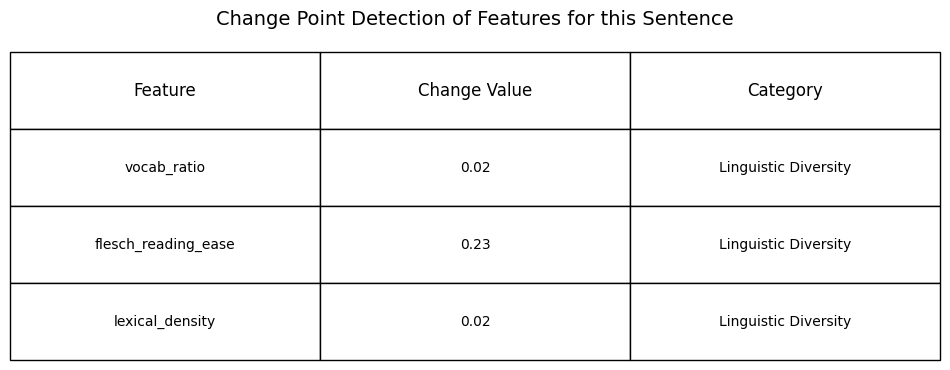


Category Averages for this Explanation:
  Linguistic Diversity: 0.0906

Overall Average for this Explanation: 0.0906
The text is likely AI-generated.

Change detected in sentence: The market believes it could be problematic if the US pivots back to narrow economic nationalism which involves bringing goods and services production back to the United States, or putting up barriers to immigration.
Feature changes:


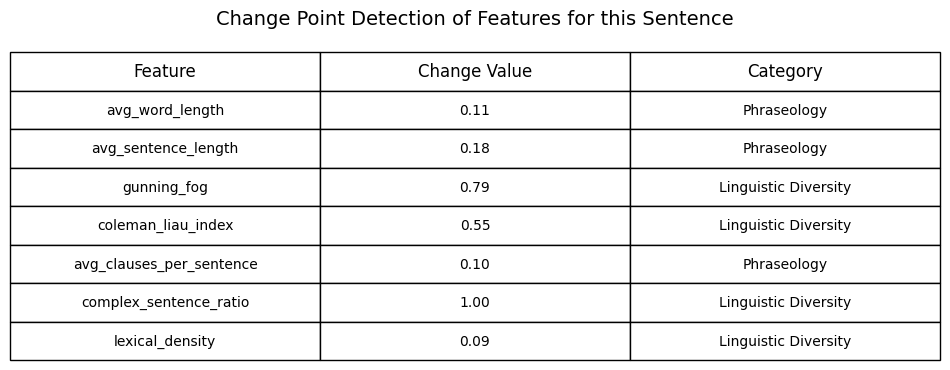


Category Averages for this Explanation:
  Phraseology: 0.1308
  Linguistic Diversity: 0.6058

Overall Average for this Explanation: 0.3683
The text is likely human-written.

Change detected in sentence: Yet, CNN’s initial exit polls indicate that only about a third of voters thought the economy is in good or excellent shape, down from about half who said the same in 2020.
Feature changes:


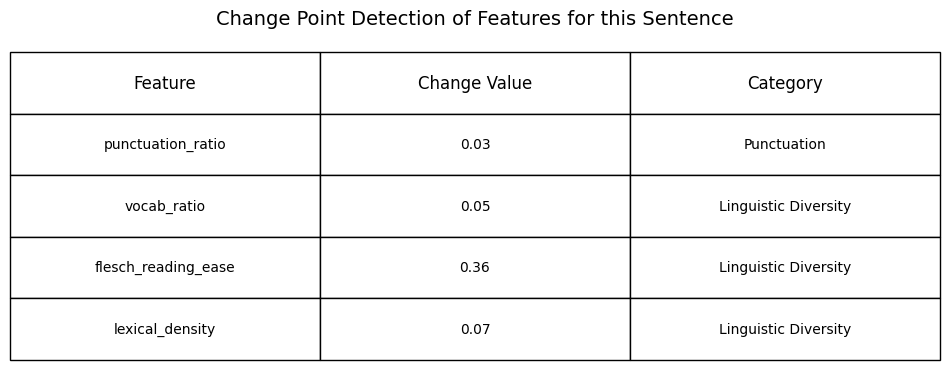


Category Averages for this Explanation:
  Punctuation: 0.0349
  Linguistic Diversity: 0.1600

Overall Average for this Explanation: 0.0975
The text is likely AI-generated.

Change detected in sentence: This is not good for Kamala.
Feature changes:


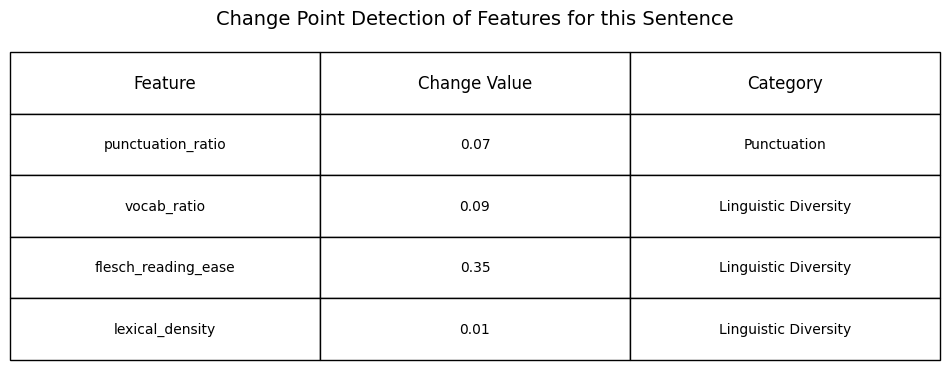


Category Averages for this Explanation:
  Punctuation: 0.0729
  Linguistic Diversity: 0.1509

Overall Average for this Explanation: 0.1119
The text is likely AI-generated.

Change detected in sentence: This seems to confirm Donald’s claim throughout the campaign that the Americans are not getting a fair deal.
Feature changes:


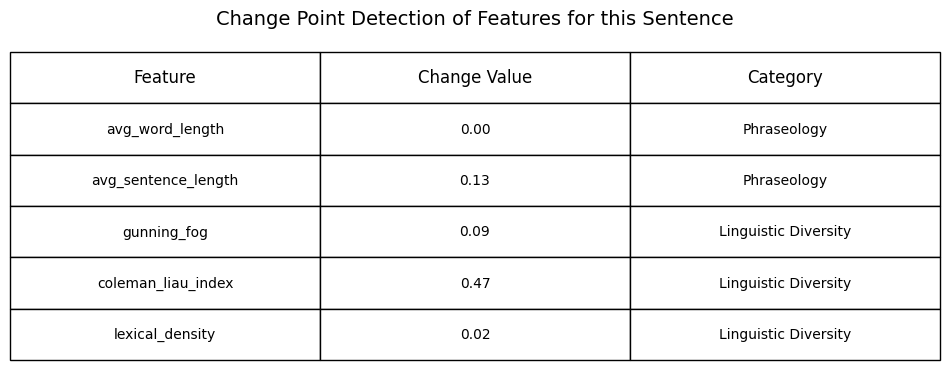


Category Averages for this Explanation:
  Phraseology: 0.0660
  Linguistic Diversity: 0.1931

Overall Average for this Explanation: 0.1296
The text is likely AI-generated.

Change detected in sentence: True, if the IMF’s World Economic Outlook for October 2024 is to be a lead, the projected US growth was actually revised up to 2.8 percent from July’s forecast of 2.6 percent this year.
Feature changes:


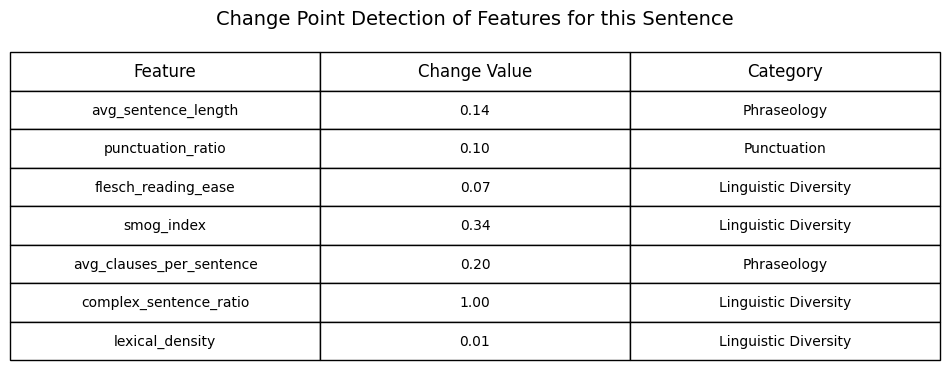


Category Averages for this Explanation:
  Phraseology: 0.1700
  Punctuation: 0.0989
  Linguistic Diversity: 0.3543

Overall Average for this Explanation: 0.2077
The text is likely human-written.

Change detected in sentence: But some emerging risks could be higher.
Feature changes:


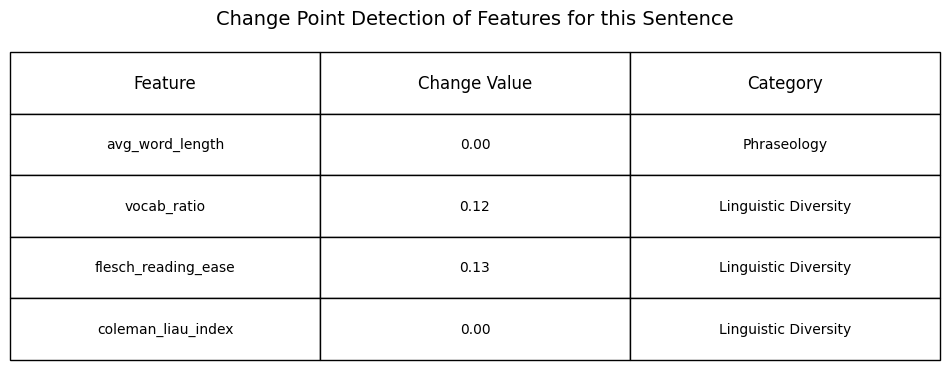


Category Averages for this Explanation:
  Phraseology: 0.0000
  Linguistic Diversity: 0.0831

Overall Average for this Explanation: 0.0416
The text is likely AI-generated.

Change detected in sentence: For instance, US inflation is expected to persist and keep the US Fed cautious with its easing mode.
Feature changes:


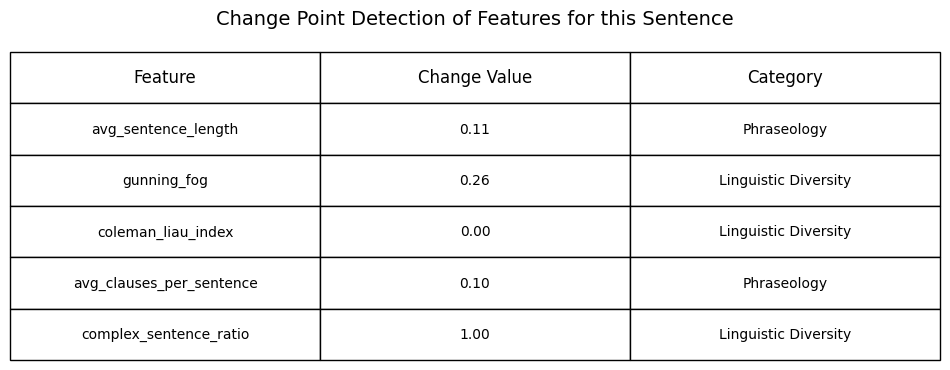


Category Averages for this Explanation:
  Phraseology: 0.1050
  Linguistic Diversity: 0.4194

Overall Average for this Explanation: 0.2622
The text is likely human-written.

Change detected in sentence: Indeed, it is about to hold its monetary policy meeting this week and the bet is on a controlled easing if not an altogether steady stance.
Feature changes:


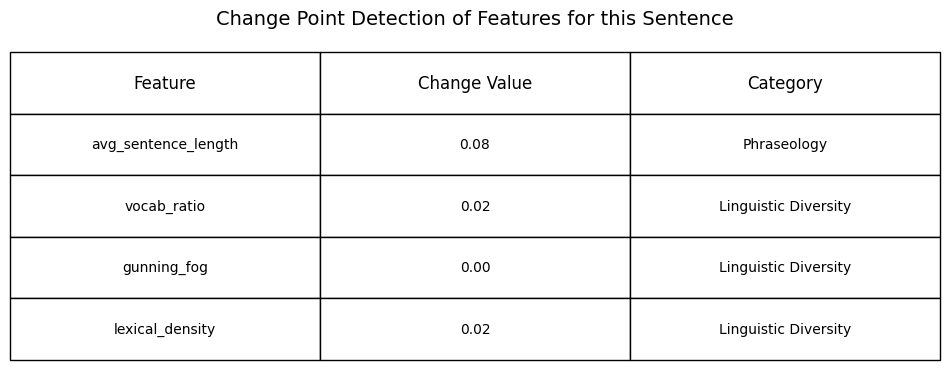


Category Averages for this Explanation:
  Phraseology: 0.0800
  Linguistic Diversity: 0.0128

Overall Average for this Explanation: 0.0464
The text is likely AI-generated.

Change detected in sentence: Interest rate expectations could remain elevated and the US dollar firm.
Feature changes:


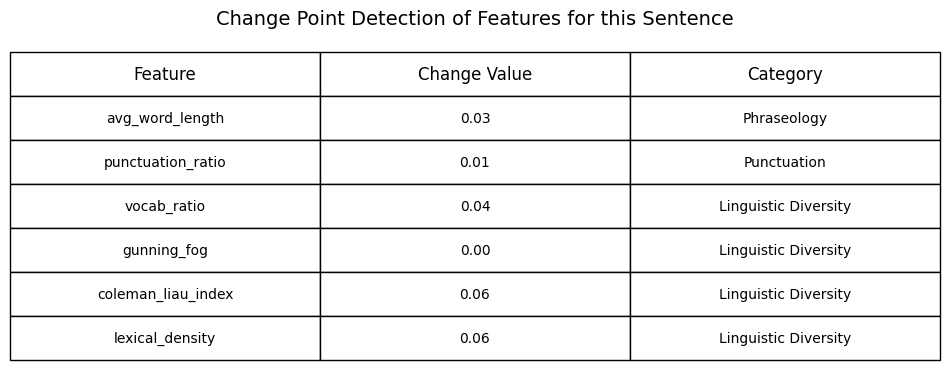


Category Averages for this Explanation:
  Phraseology: 0.0264
  Punctuation: 0.0140
  Linguistic Diversity: 0.0395

Overall Average for this Explanation: 0.0266
The text is likely AI-generated.

Change detected in sentence: These are not actually growth-positive.
Feature changes:


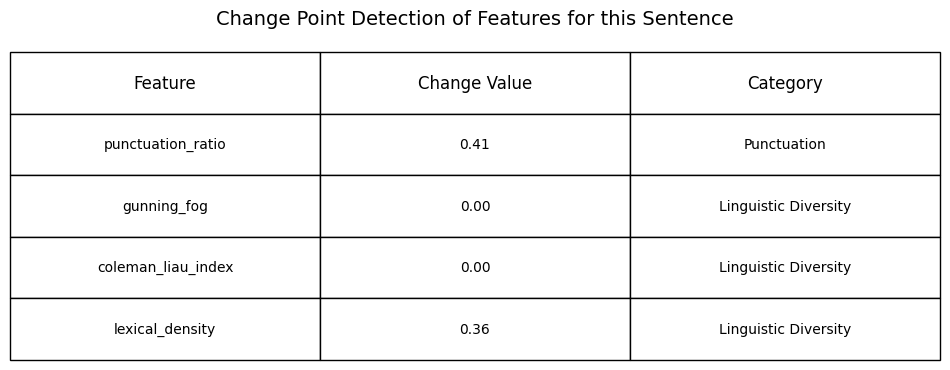


Category Averages for this Explanation:
  Punctuation: 0.4091
  Linguistic Diversity: 0.1212

Overall Average for this Explanation: 0.2652
The text is likely human-written.

Change detected in sentence: Funding-wise, if the US Fed decides to be more cautious — perhaps in anticipation of the potential fallout from the election — emerging markets’ ability to borrow and service their loans in the US capital markets may be at risk.
Feature changes:


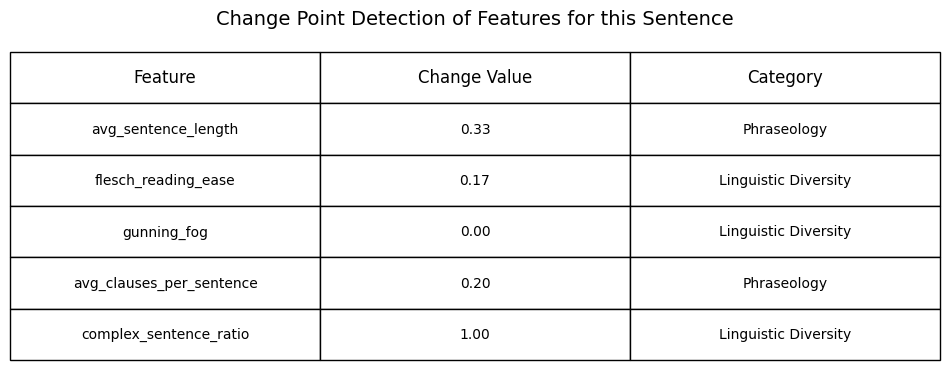


Category Averages for this Explanation:
  Phraseology: 0.2650
  Linguistic Diversity: 0.3909

Overall Average for this Explanation: 0.3279
The text is likely human-written.

Change detected in sentence: As Fitch Ratings recently reported, the Philippines is among a few sovereigns who issued foreign-currency debt in the third quarter.
Feature changes:


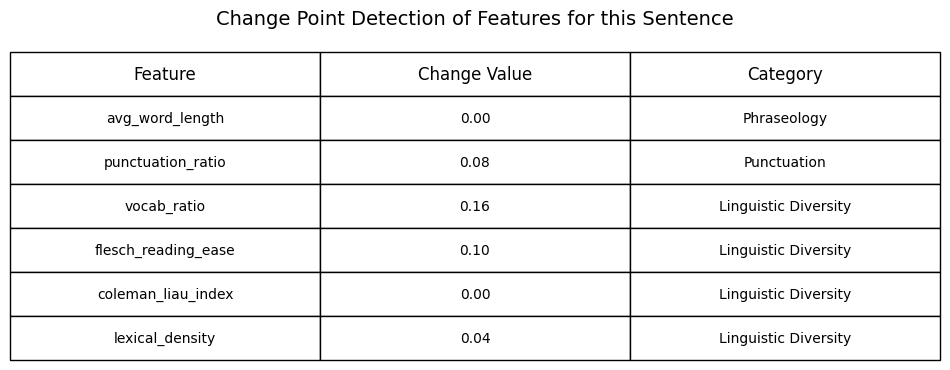


Category Averages for this Explanation:
  Phraseology: 0.0000
  Punctuation: 0.0768
  Linguistic Diversity: 0.0743

Overall Average for this Explanation: 0.0504
The text is likely AI-generated.

Change detected in sentence: The country’s external debt is now at an all-time high of $130.2 billion.
Feature changes:


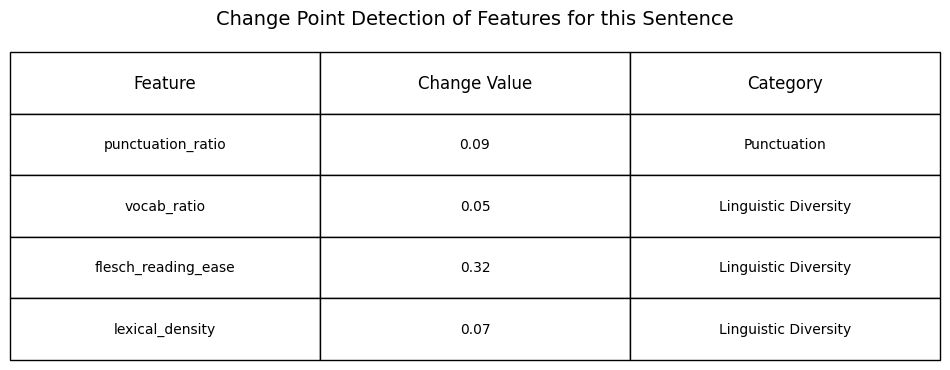


Category Averages for this Explanation:
  Punctuation: 0.0921
  Linguistic Diversity: 0.1477

Overall Average for this Explanation: 0.1199
The text is likely AI-generated.

Change detected in sentence: For emerging markets like the Philippines, monetary policy could be most appropriate, measured as necessary, but they could also be driven by geopolitical factors like the US election’s collateral impact on their trade, migration and macroeconomic policy.
Feature changes:


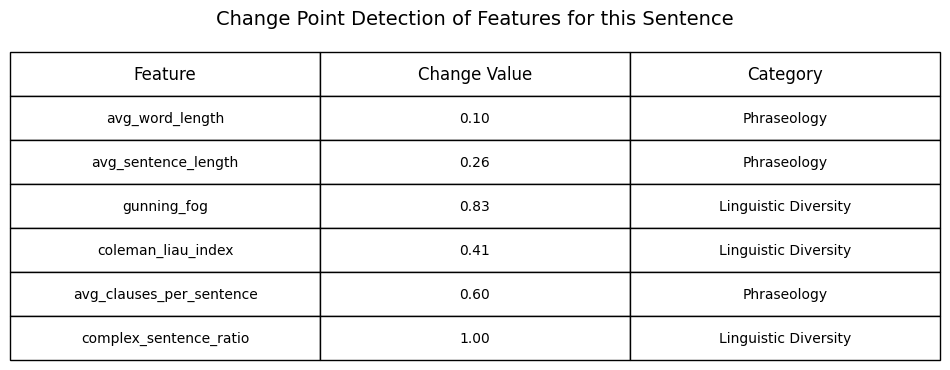


Category Averages for this Explanation:
  Phraseology: 0.3183
  Linguistic Diversity: 0.7470

Overall Average for this Explanation: 0.5327
The text is likely human-written.

Change detected in sentence: Beyond these, there are pressing domestic issues that could downgrade their growth prospects.
Feature changes:


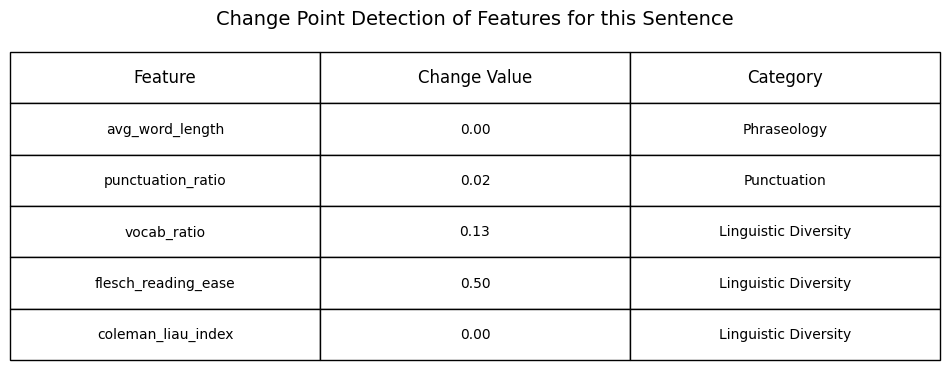


Category Averages for this Explanation:
  Phraseology: 0.0000
  Punctuation: 0.0223
  Linguistic Diversity: 0.2097

Overall Average for this Explanation: 0.0773
The text is likely AI-generated.

Change detected in sentence: In this country, climate change is causing devastation to both agriculture and industry.
Feature changes:


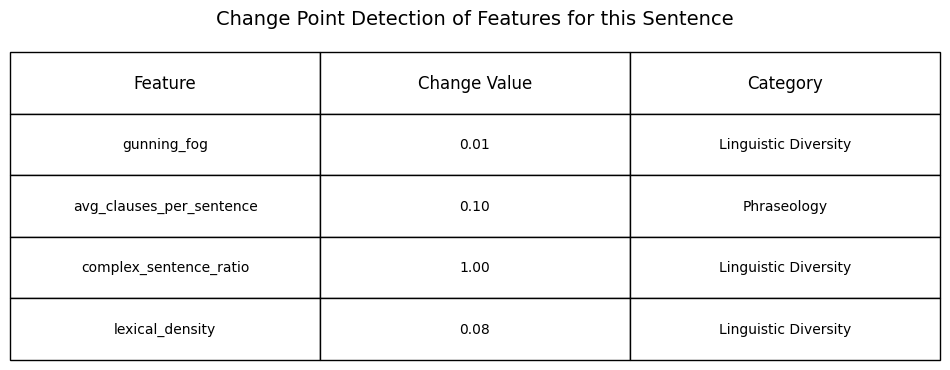


Category Averages for this Explanation:
  Phraseology: 0.1000
  Linguistic Diversity: 0.3635

Overall Average for this Explanation: 0.2318
The text is likely human-written.

Change detected in sentence: The Department of Agriculture recently estimated that El Niño and the series of typhoons and tropical storms reduced palay supply by more than one million metric tons (MT) for the last 10 months of 2024.
Feature changes:


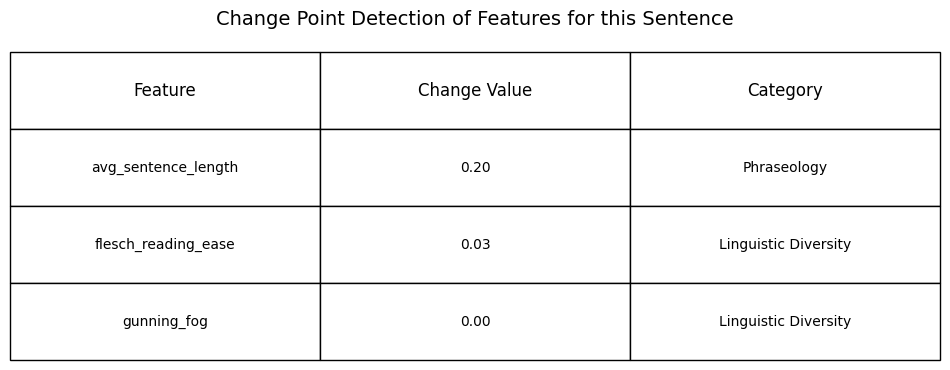


Category Averages for this Explanation:
  Phraseology: 0.2000
  Linguistic Diversity: 0.0152

Overall Average for this Explanation: 0.1076
The text is likely AI-generated.

Change detected in sentence: Historical losses averaged only 500-600,000 MT.
Feature changes:


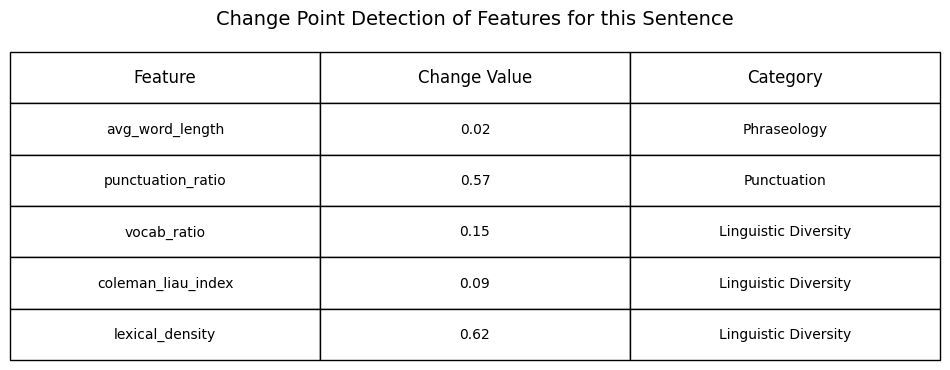


Category Averages for this Explanation:
  Phraseology: 0.0168
  Punctuation: 0.5697
  Linguistic Diversity: 0.2883

Overall Average for this Explanation: 0.2916
The text is likely human-written.

Change detected in sentence: In terms of milled rice, it means we need to import an additional 670,000 MT.
Feature changes:


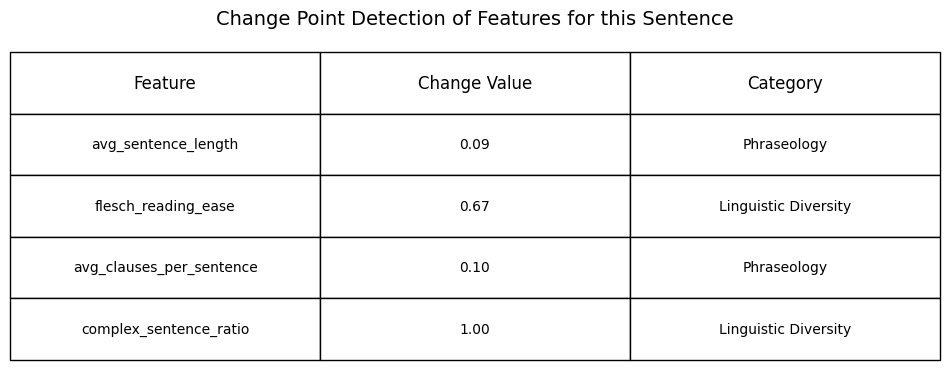


Category Averages for this Explanation:
  Phraseology: 0.0950
  Linguistic Diversity: 0.8350

Overall Average for this Explanation: 0.4650
The text is likely human-written.

Change detected in sentence: If imports foul up, inflation could definitely run up and weaken personal consumption and therefore growth.
Feature changes:


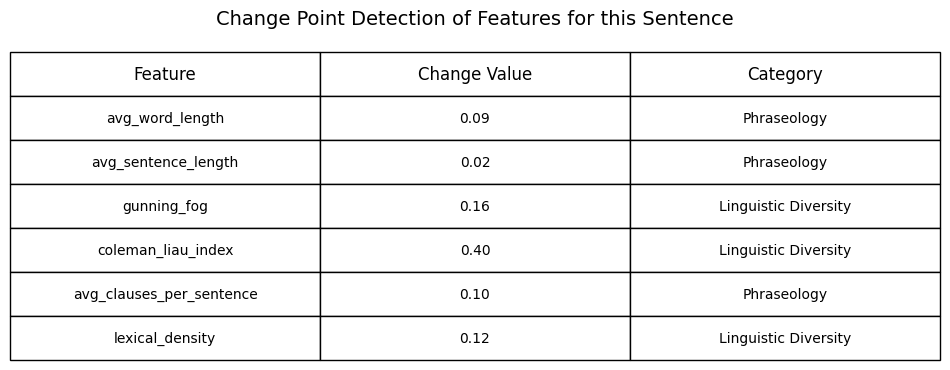


Category Averages for this Explanation:
  Phraseology: 0.0684
  Linguistic Diversity: 0.2231

Overall Average for this Explanation: 0.1457
The text is likely AI-generated.

Change detected in sentence: These weather shocks also underpin the deceleration in manufacturing activity in October.
Feature changes:


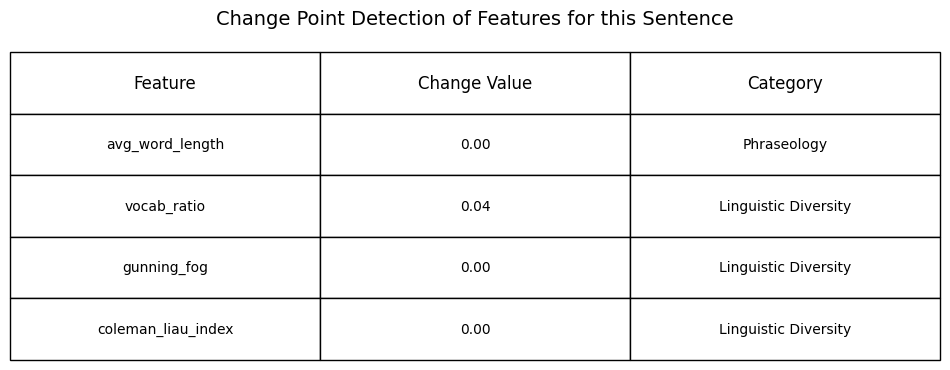


Category Averages for this Explanation:
  Phraseology: 0.0000
  Linguistic Diversity: 0.0139

Overall Average for this Explanation: 0.0069
The text is likely AI-generated.

Change detected in sentence: The country’s purchasing managers’ index (PMI) fell from 53.7 to 52.9, still showing an expansion but at a slower rate.
Feature changes:


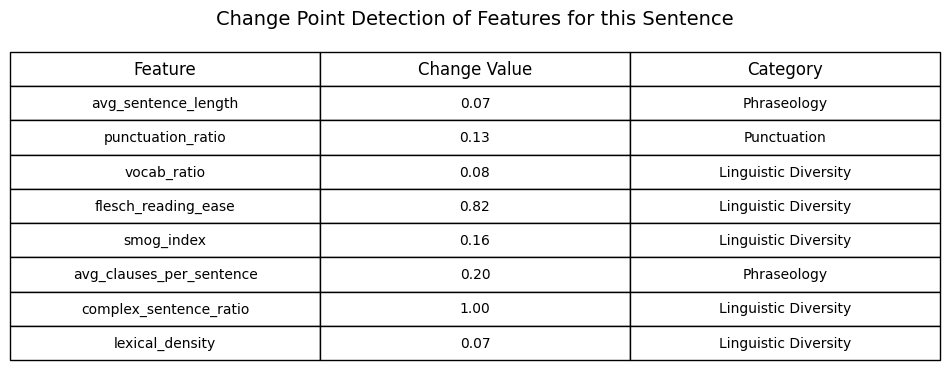


Category Averages for this Explanation:
  Phraseology: 0.1350
  Punctuation: 0.1272
  Linguistic Diversity: 0.4265

Overall Average for this Explanation: 0.2296
The text is likely human-written.

Change detected in sentence: A lower reading indicates lower increase in new business orders and output.
Feature changes:


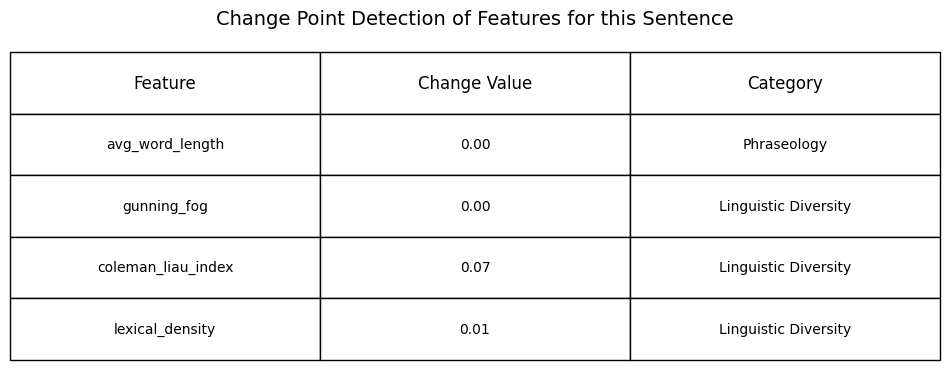


Category Averages for this Explanation:
  Phraseology: 0.0000
  Linguistic Diversity: 0.0277

Overall Average for this Explanation: 0.0139
The text is likely AI-generated.

Change detected in sentence: Although the highest in the ASEAN, the Philippines’ PMI reflects some slight deterioration in any of the following: new orders, output, employment, suppliers’ delivery times and stocks of purchases.
Feature changes:


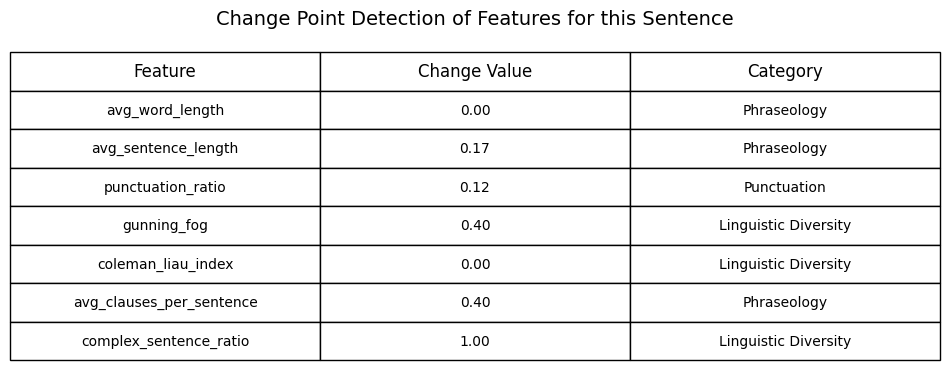


Category Averages for this Explanation:
  Phraseology: 0.1900
  Punctuation: 0.1236
  Linguistic Diversity: 0.4658

Overall Average for this Explanation: 0.2598
The text is likely human-written.

Change detected in sentence: The other risk is fiscal space.
Feature changes:


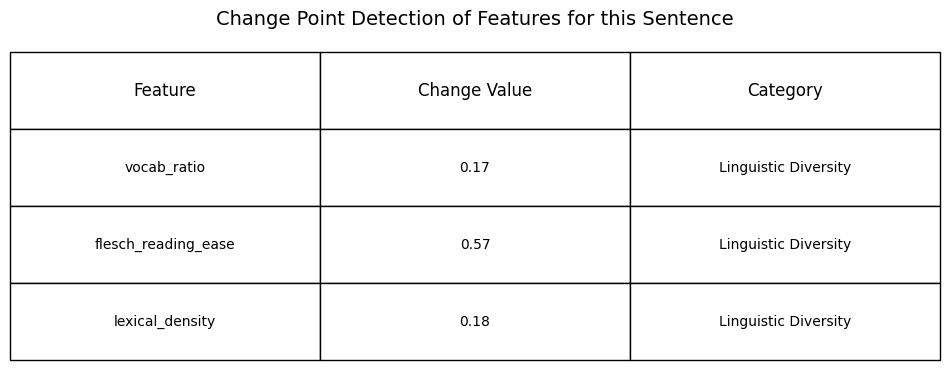


Category Averages for this Explanation:
  Linguistic Diversity: 0.3075

Overall Average for this Explanation: 0.3075
The text is likely human-written.

Change detected in sentence: National government (NG) cash operations continue to bleed with a deficit reaching ₱970 billion for the first three quarters of the year which could tip at between five to six percent of GDP.
Feature changes:


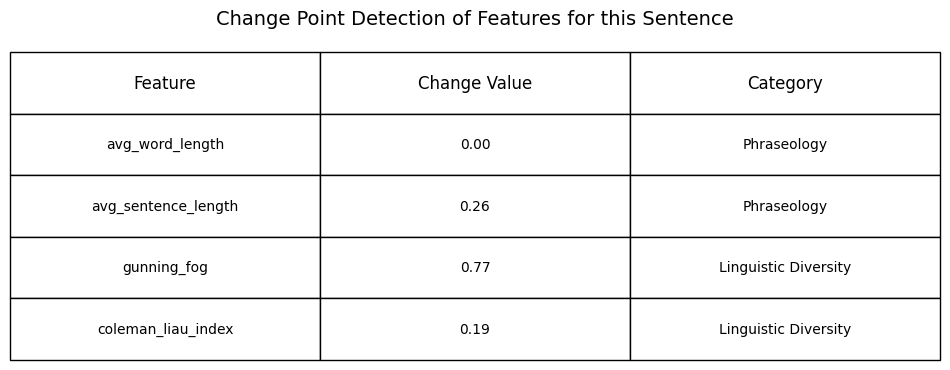


Category Averages for this Explanation:
  Phraseology: 0.1300
  Linguistic Diversity: 0.4761

Overall Average for this Explanation: 0.3031
The text is likely human-written.

Change detected in sentence: With taxation relegated to the backburner, NG has ramped up public debt now at ₱15.9 trillion, about three years of the country’s annual budget.
Feature changes:


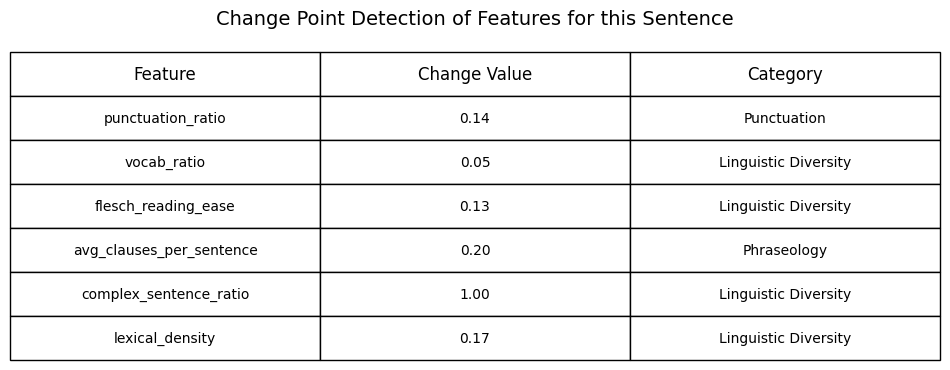


Category Averages for this Explanation:
  Phraseology: 0.2000
  Punctuation: 0.1354
  Linguistic Diversity: 0.3368

Overall Average for this Explanation: 0.2241
The text is likely human-written.

Change detected in sentence: For debt servicing, NG spent ₱751 billion last year, and for the first eight months of 2024, ₱915 billion or around 15 percent of the annual budget.
Feature changes:


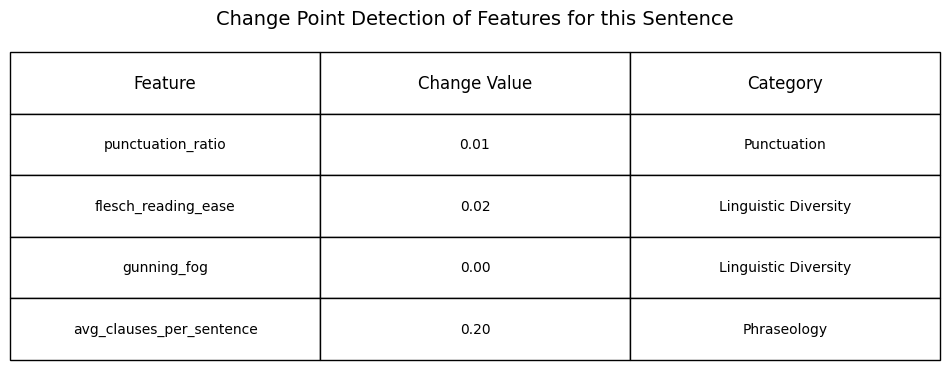


Category Averages for this Explanation:
  Phraseology: 0.2000
  Punctuation: 0.0072
  Linguistic Diversity: 0.0084

Overall Average for this Explanation: 0.0719
The text is likely AI-generated.

Change detected in sentence: If the Supreme Court decides to invalidate the Department of Finance’s directive to turn over PhilHealth’s “idle, unused and excess funds” that means NG would have less ₱89.9 billion from its funding side, unless this is matched by a higher borrowing.
Feature changes:


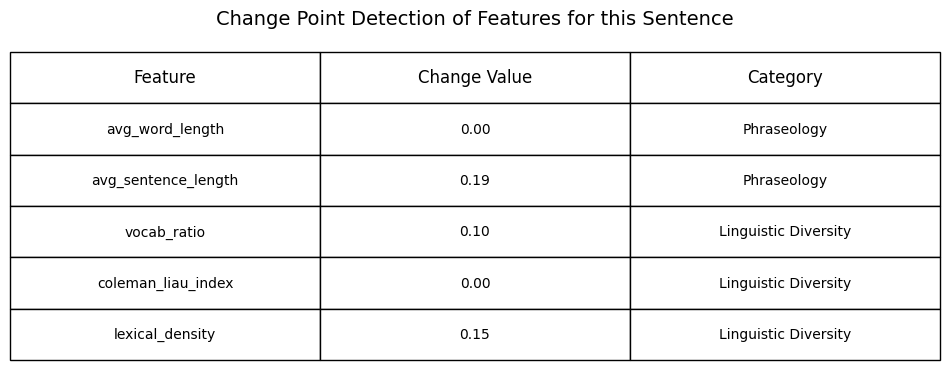


Category Averages for this Explanation:
  Phraseology: 0.0950
  Linguistic Diversity: 0.0839

Overall Average for this Explanation: 0.0894
The text is likely AI-generated.

Change detected in sentence: This is hardly growth-positive.
Feature changes:


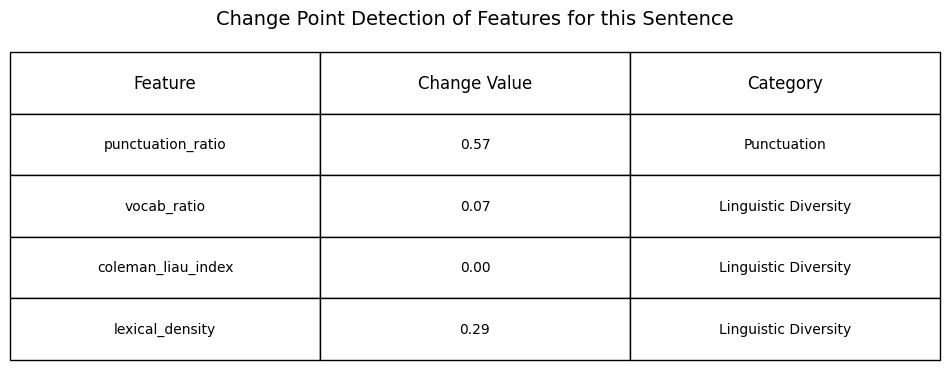


Category Averages for this Explanation:
  Punctuation: 0.5714
  Linguistic Diversity: 0.1190

Overall Average for this Explanation: 0.3452
The text is likely human-written.

Change detected in sentence: With poor allocation of the budget — pork barrel, intelligence and confidential funds, and weak monitoring of flood control projects, and all that — we doubt whether the basic issues of human capital development and infrastructure could be given sufficient support.
Feature changes:


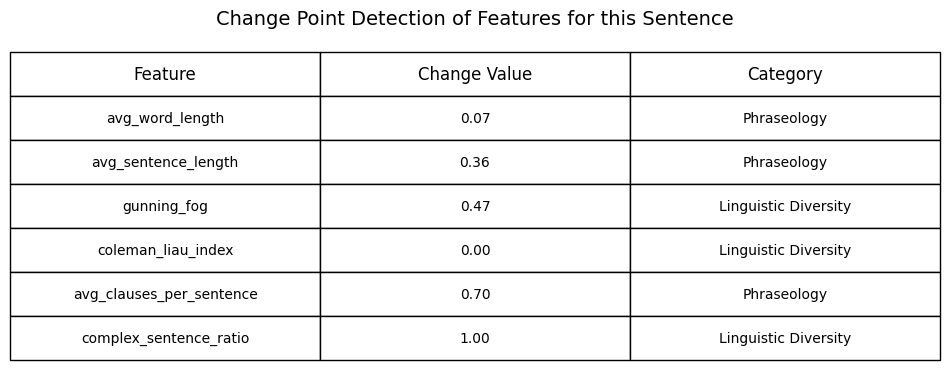


Category Averages for this Explanation:
  Phraseology: 0.3761
  Linguistic Diversity: 0.4903

Overall Average for this Explanation: 0.4332
The text is likely human-written.

Change detected in sentence: Human capital is developed when we spend enough for education and health, and when we spend more for innovation through higher levels of research and development.
Feature changes:


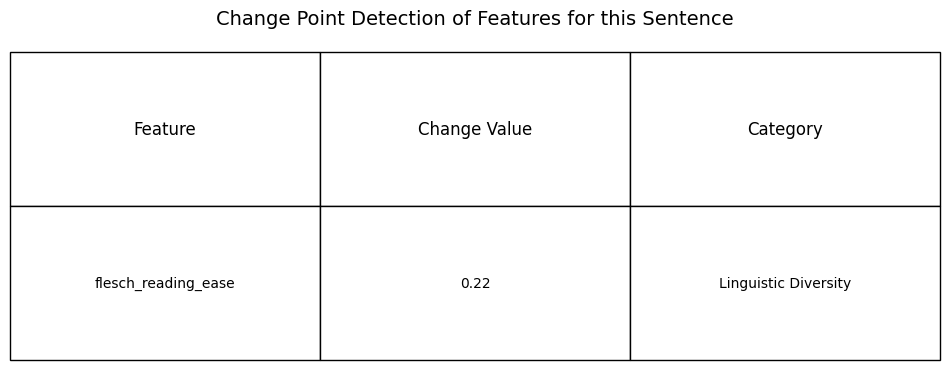


Category Averages for this Explanation:
  Linguistic Diversity: 0.2166

Overall Average for this Explanation: 0.2166
The text is likely human-written.

Change detected in sentence: Our own National Innovation Council, in charge of formulating the development of the National Innovation Agenda and Strategy Document or NIASD, is just beginning.
Feature changes:


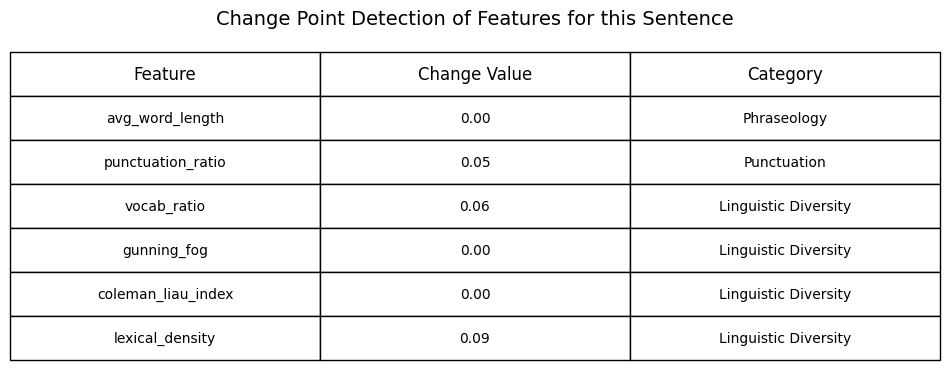


Category Averages for this Explanation:
  Phraseology: 0.0000
  Punctuation: 0.0481
  Linguistic Diversity: 0.0385

Overall Average for this Explanation: 0.0288
The text is likely AI-generated.

Change detected in sentence: The secretariat housed in NEDA has little institutional character and funding.
Feature changes:


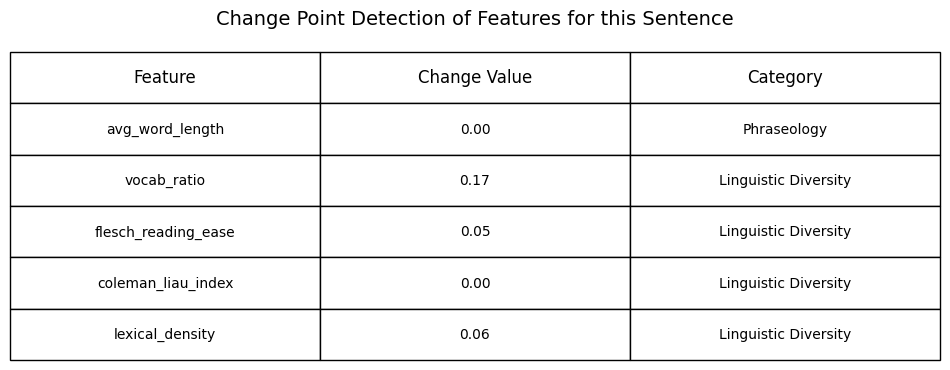


Category Averages for this Explanation:
  Phraseology: 0.0000
  Linguistic Diversity: 0.0686

Overall Average for this Explanation: 0.0343
The text is likely AI-generated.

Change detected in sentence: No government can overemphasize enough the enormous value added of education, training, skills set, innovation and digital transformation in elevating and maintaining both the growth momentum and the quality of growth.
Feature changes:


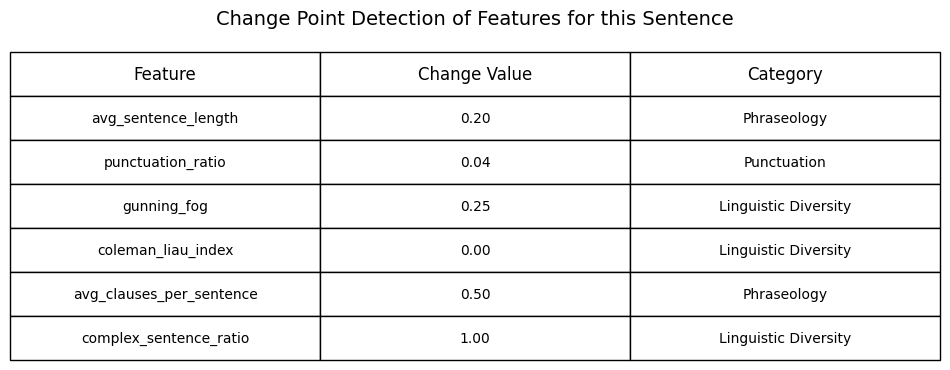


Category Averages for this Explanation:
  Phraseology: 0.3500
  Punctuation: 0.0381
  Linguistic Diversity: 0.4152

Overall Average for this Explanation: 0.2678
The text is likely human-written.

Change detected in sentence: Infrastructure, on the other hand, as represented by the government’s 13 flagship projects aimed at establishing physical connectivity, water resources, digital connectivity and health, has barely taken off the ground.
Feature changes:


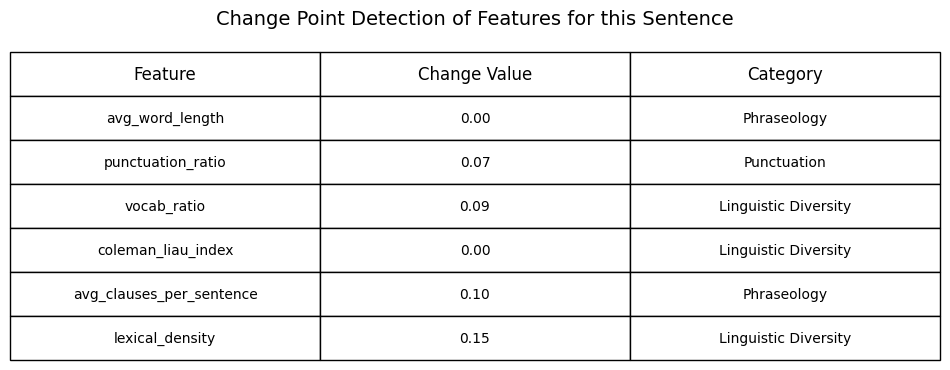


Category Averages for this Explanation:
  Phraseology: 0.0500
  Punctuation: 0.0710
  Linguistic Diversity: 0.0821

Overall Average for this Explanation: 0.0677
The text is likely AI-generated.

Change detected in sentence: As of March 2024, only two have been completed.
Feature changes:


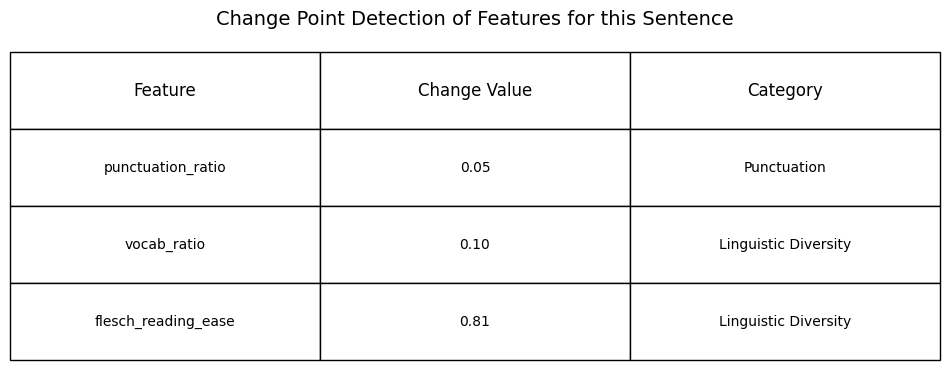


Category Averages for this Explanation:
  Punctuation: 0.0500
  Linguistic Diversity: 0.4526

Overall Average for this Explanation: 0.2513
The text is likely human-written.

Change detected in sentence: The government should assure the civil society of the higher likelihood of the other 11 being completed this year even as the August 2024 infrastructure spending actually declined by 11 percent.
Feature changes:


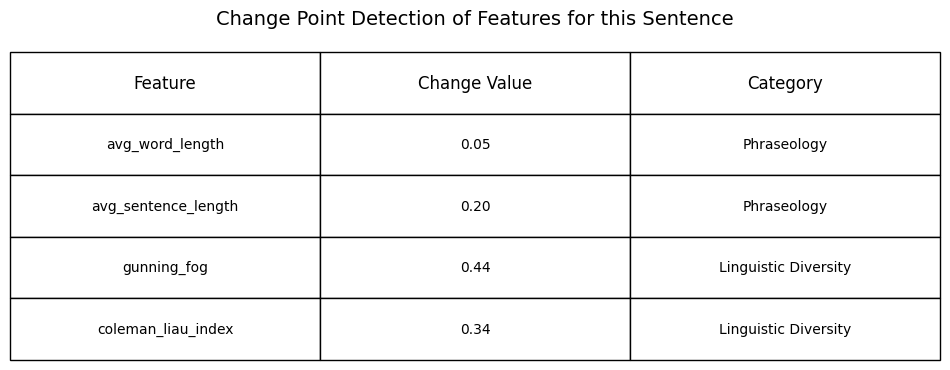


Category Averages for this Explanation:
  Phraseology: 0.1228
  Linguistic Diversity: 0.3870

Overall Average for this Explanation: 0.2549
The text is likely human-written.

Change detected in sentence: To be sure, good and quality infrastructure increases the sustainability of growth.
Feature changes:


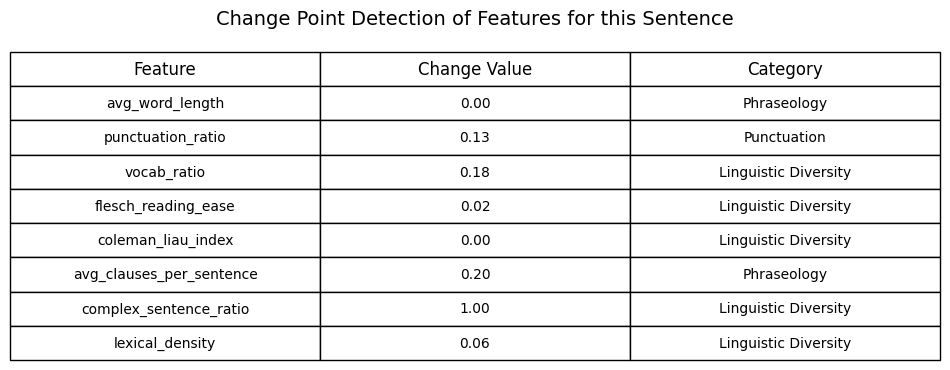


Category Averages for this Explanation:
  Phraseology: 0.1000
  Punctuation: 0.1310
  Linguistic Diversity: 0.2524

Overall Average for this Explanation: 0.1611
The text is likely human-written.

Change detected in sentence: Whatever shortfall in domestic investment can be very well complemented by foreign investment which would not need additional incentive to come and invest in the Philippines.
Feature changes:


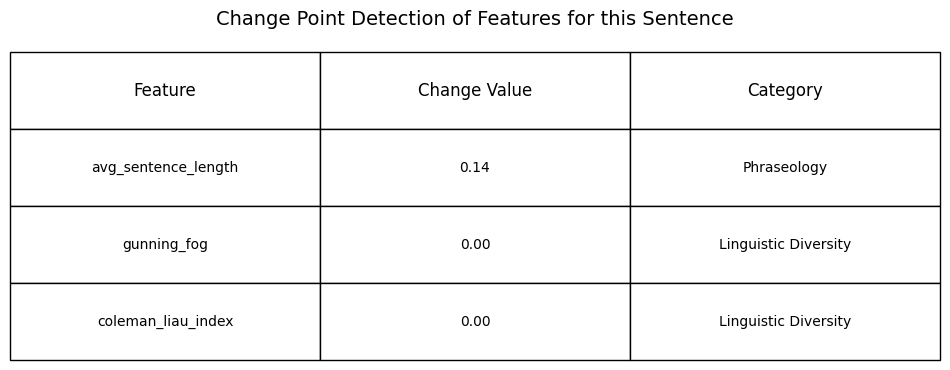


Category Averages for this Explanation:
  Phraseology: 0.1400
  Linguistic Diversity: 0.0000

Overall Average for this Explanation: 0.0700
The text is likely AI-generated.

Change detected in sentence: With good infra backbone and people, we have what it takes to host successful business ventures.
Feature changes:


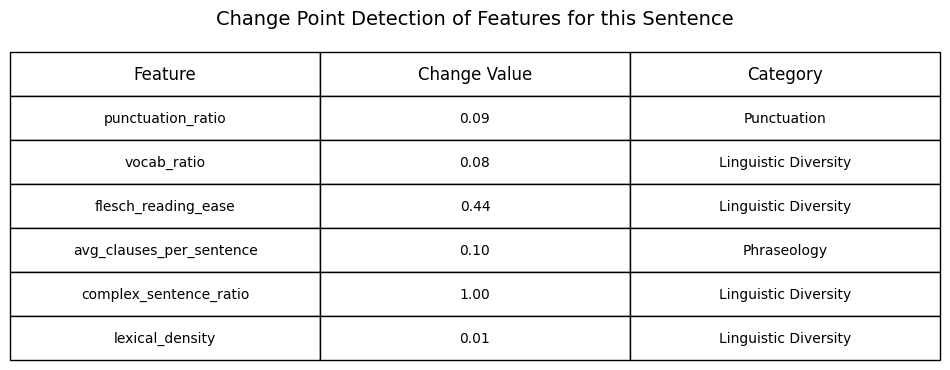


Category Averages for this Explanation:
  Phraseology: 0.1000
  Punctuation: 0.0865
  Linguistic Diversity: 0.3816

Overall Average for this Explanation: 0.1894
The text is likely human-written.

Change detected in sentence: Already, some observers of the Philippine growth story have begun to forecast lower growth for the country.
Feature changes:


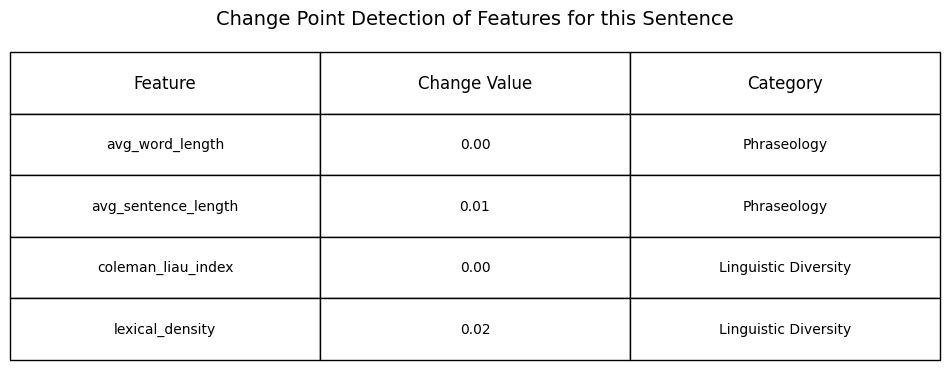


Category Averages for this Explanation:
  Phraseology: 0.0050
  Linguistic Diversity: 0.0110

Overall Average for this Explanation: 0.0080
The text is likely AI-generated.

Change detected in sentence: For instance, the Fund at the conclusion of the 2024 Article IV consultation announced forecast below-target growth rates of 5.8 percent and 6.1 percent for 2024 and 2025, respectively, on account of the expected slowdown in major economies and potential increases in commodity prices.
Feature changes:


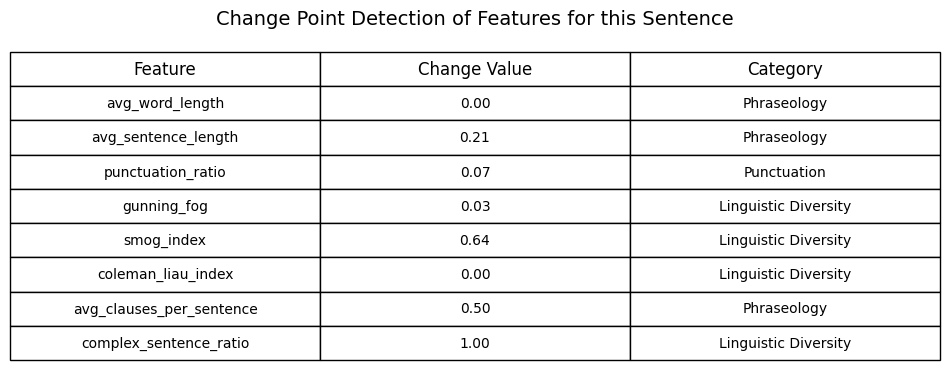


Category Averages for this Explanation:
  Phraseology: 0.2367
  Punctuation: 0.0666
  Linguistic Diversity: 0.4170

Overall Average for this Explanation: 0.2401
The text is likely human-written.

Change detected in sentence: The Fund, however, places some confidence that if properly harnessed, the country’s abundant natural resources, untapped blue economy and its demographic advantage could by all means secure for the Philippines a more vigorous, more resilient economy.
Feature changes:


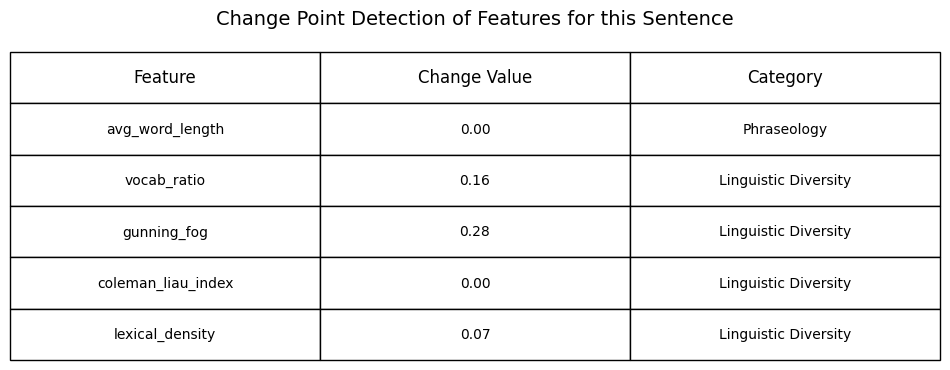


Category Averages for this Explanation:
  Phraseology: 0.0000
  Linguistic Diversity: 0.1252

Overall Average for this Explanation: 0.0626
The text is likely AI-generated.

Change detected in sentence: Moody’s Analytics broadly shares this view in its assessment of the growth prospect for the third quarter of 5.7 percent.
Feature changes:


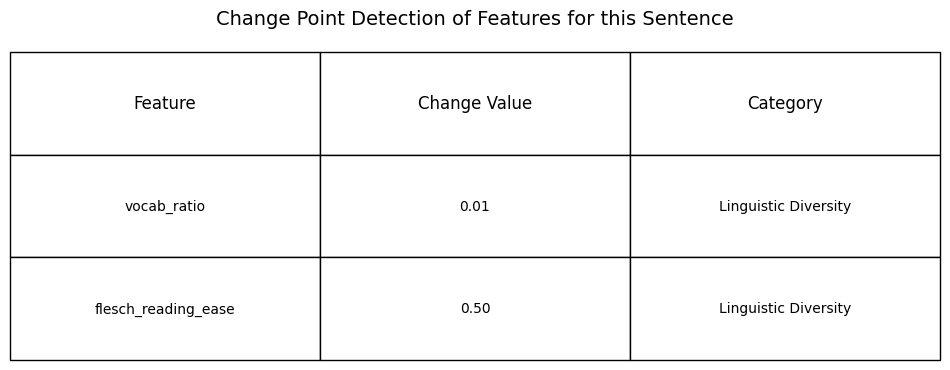


Category Averages for this Explanation:
  Linguistic Diversity: 0.2545

Overall Average for this Explanation: 0.2545
The text is likely human-written.

Change detected in sentence: It is not too sanguine about the impact of the BSP’s rate cuts because of the lag time, while exports may “lose some shine” due to soft external demand and slowdown in world tourist arrivals.
Feature changes:


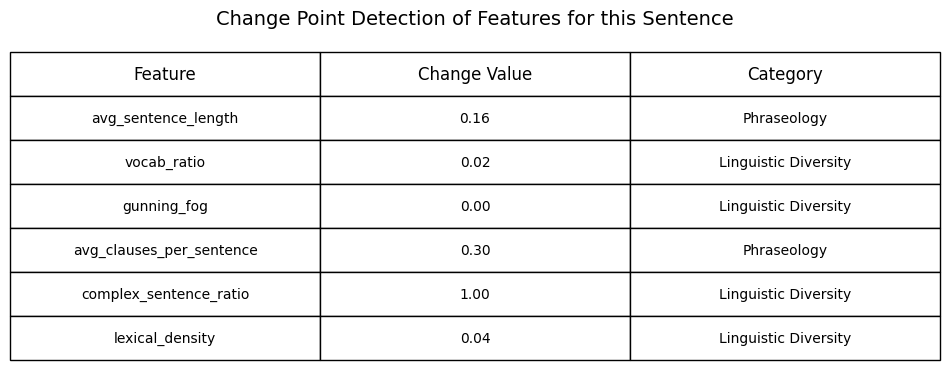


Category Averages for this Explanation:
  Phraseology: 0.2300
  Linguistic Diversity: 0.2653

Overall Average for this Explanation: 0.2476
The text is likely human-written.

Change detected in sentence: While the issue between Donald and Kamala could be existential for some countries, our hands are quite full with household problems and challenges.
Feature changes:


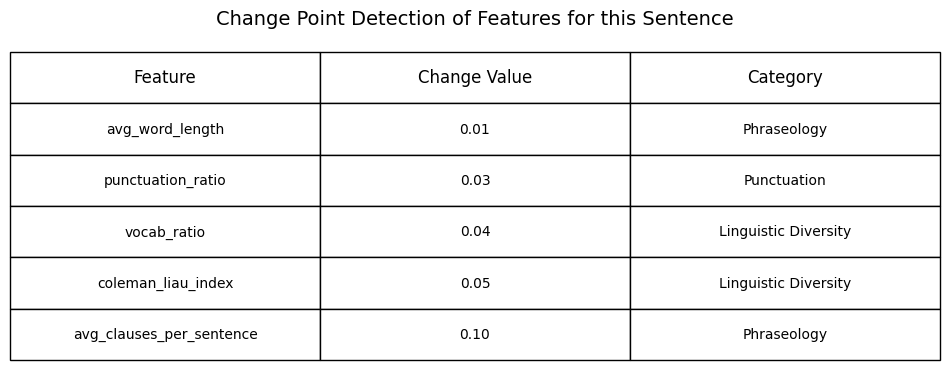


Category Averages for this Explanation:
  Phraseology: 0.0570
  Punctuation: 0.0314
  Linguistic Diversity: 0.0437

Overall Average for this Explanation: 0.0440
The text is likely AI-generated.

Change detected in sentence: Good governance could not be more pressing than now
Feature changes:


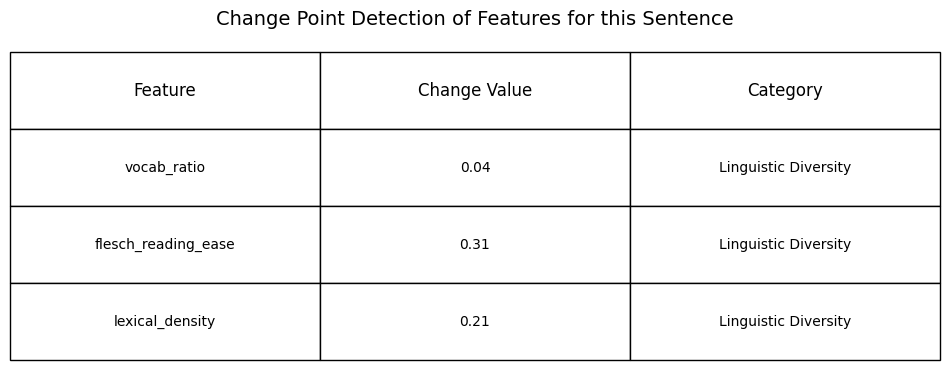


Category Averages for this Explanation:
  Linguistic Diversity: 0.1891

Overall Average for this Explanation: 0.1891
The text is likely human-written.

Changepoint Detection DataFrame:


,Sentence Index,Sentence,Feature,Change Value,Category
0,1,"In a few hours, the world will know whether it...",vocab_ratio,0.017857,Linguistic Diversity
1,1,"In a few hours, the world will know whether it...",flesch_reading_ease,0.230100,Linguistic Diversity
2,1,"In a few hours, the world will know whether it...",lexical_density,0.023810,Linguistic Diversity
3,2,The market believes it could be problematic if...,avg_word_length,0.112337,Phraseology
4,2,The market believes it could be problematic if...,avg_sentence_length,0.180000,Phraseology
...,...,...,...,...,...
232,48,While the issue between Donald and Kamala coul...,coleman_liau_index,0.047500,Linguistic Diversity
233,48,While the issue between Donald and Kamala coul...,avg_clauses_per_sentence,0.100000,Phraseology
234,49,Good governance could not be more pressing tha...,vocab_ratio,0.043478,Linguistic Diversity
235,49,Good governance could not be more pressing tha...,flesch_reading_ease,0.311300,Linguistic Diversity


In [19]:
new_text = """As we wrote this piece, the election in the US was likened into a woman in travail, laboring in child birth. In a few hours, the world will know whether it’s a Donald or a Kamala. The market believes it could be problematic if the US pivots back to narrow economic nationalism which involves bringing goods and services production back to the United States, or putting up barriers to immigration. Yet, CNN’s initial exit polls indicate that only about a third of voters thought the economy is in good or excellent shape, down from about half who said the same in 2020. This is not good for Kamala. This seems to confirm Donald’s claim throughout the campaign that the Americans are not getting a fair deal. 

 

True, if the IMF’s World Economic Outlook for October 2024 is to be a lead, the projected US growth was actually revised up to 2.8 percent from July’s forecast of 2.6 percent this year. But some emerging risks could be higher. For instance, US inflation is expected to persist and keep the US Fed cautious with its easing mode. Indeed, it is about to hold its monetary policy meeting this week and the bet is on a controlled easing if not an altogether steady stance. Interest rate expectations could remain elevated and the US dollar firm. These are not actually growth-positive. 

 

Funding-wise, if the US Fed decides to be more cautious — perhaps in anticipation of the potential fallout from the election — emerging markets’ ability to borrow and service their loans in the US capital markets may be at risk. As Fitch Ratings recently reported, the Philippines is among a few sovereigns who issued foreign-currency debt in the third quarter. The country’s external debt is now at an all-time high of $130.2 billion. 

 

For emerging markets like the Philippines, monetary policy could be most appropriate, measured as necessary, but they could also be driven by geopolitical factors like the US election’s collateral impact on their trade, migration and macroeconomic policy. Beyond these, there are pressing domestic issues that could downgrade their growth prospects.

 

In this country, climate change is causing devastation to both agriculture and industry. The Department of Agriculture recently estimated that El Niño and the series of typhoons and tropical storms reduced palay supply by more than one million metric tons (MT) for the last 10 months of 2024. Historical losses averaged only 500-600,000 MT. In terms of milled rice, it means we need to import an additional 670,000 MT. If imports foul up, inflation could definitely run up and weaken personal consumption and therefore growth.

 

These weather shocks also underpin the deceleration in manufacturing activity in October. The country’s purchasing managers’ index (PMI) fell from 53.7 to 52.9, still showing an expansion but at a slower rate. A lower reading indicates lower increase in new business orders and output. Although the highest in the ASEAN, the Philippines’ PMI reflects some slight deterioration in any of the following: new orders, output, employment, suppliers’ delivery times and stocks of purchases. 

 

The other risk is fiscal space. National government (NG) cash operations continue to bleed with a deficit reaching ₱970 billion for the first three quarters of the year which could tip at between five to six percent of GDP. With taxation relegated to the backburner, NG has ramped up public debt now at ₱15.9 trillion, about three years of the country’s annual budget. For debt servicing, NG spent ₱751 billion last year, and for the first eight months of 2024, ₱915 billion or around 15 percent of the annual budget. 

 

If the Supreme Court decides to invalidate the Department of Finance’s directive to turn over PhilHealth’s “idle, unused and excess funds” that means NG would have less ₱89.9 billion from its funding side, unless this is matched by a higher borrowing. This is hardly growth-positive. 

 

With poor allocation of the budget — pork barrel, intelligence and confidential funds, and weak monitoring of flood control projects, and all that — we doubt whether the basic issues of human capital development and infrastructure could be given sufficient support.

 

Human capital is developed when we spend enough for education and health, and when we spend more for innovation through higher levels of research and development. Our own National Innovation Council, in charge of formulating the development of the National Innovation Agenda and Strategy Document or NIASD, is just beginning. The secretariat housed in NEDA has little institutional character and funding. No government can overemphasize enough the enormous value added of education, training, skills set, innovation and digital transformation in elevating and maintaining both the growth momentum and the quality of growth. 

 

Infrastructure, on the other hand, as represented by the government’s 13 flagship projects aimed at establishing physical connectivity, water resources, digital connectivity and health, has barely taken off the ground. As of March 2024, only two have been completed. The government should assure the civil society of the higher likelihood of the other 11 being completed this year even as the August 2024 infrastructure spending actually declined by 11 percent.  To be sure, good and quality infrastructure increases the sustainability of growth. Whatever shortfall in domestic investment can be very well complemented by foreign investment which would not need additional incentive to come and invest in the Philippines. With good infra backbone and people, we have what it takes to host successful business ventures. 

 

Already, some observers of the Philippine growth story have begun to forecast lower growth for the country. For instance, the Fund at the conclusion of the 2024 Article IV consultation announced forecast below-target growth rates of 5.8 percent and 6.1 percent for 2024 and 2025, respectively, on account of the expected slowdown in major economies and potential increases in commodity prices. The Fund, however, places some confidence that if properly harnessed, the country’s abundant natural resources, untapped blue economy and its demographic advantage could by all means secure for the Philippines a more vigorous, more resilient economy.

 

Moody’s Analytics broadly shares this view in its assessment of the growth prospect for the third quarter of 5.7 percent. It is not too sanguine about the impact of the BSP’s rate cuts because of the lag time, while exports may “lose some shine” due to soft external demand and slowdown in world tourist arrivals. 

 

While the issue between Donald and Kamala could be existential for some countries, our hands are quite full with household problems and challenges. Good governance could not be more pressing than now"""
author = "Diwa C. Guinigundo"

# Detect changepoints, explanations, and changepoint DataFrame
changepoints, explanations, changepoint_df, newText_featuresdf, average_value, pred_author = detect_change_points_in_text(new_text, author, clf)

# Display options for pandas to prevent compression issues
pd.set_option('display.max_rows', 20)  # Show up to 20 rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust column width

# Display the changepoint DataFrame
print("\nChangepoint Detection DataFrame:")
display(changepoint_df)

In [20]:
# Check if the author exists in the DataFrame and has ai_label = 0
if ((df_normalized_features['author'] == author) & (df_normalized_features['ai_label'] == 0)).any():
    print(f"Author '{author}'\n")
    
    # Create copies of the DataFrames
    changepoint_ave = average_value.copy()
    predicted_auth = pred_author.copy()
    author_featuredf = df_normalized_features.copy()
    normalized_newText_featuresdf = newText_featuresdf.copy()
    
    # Normalize the required columns for the inputted text
    for col in newText_featuresdf.columns:
        if col in feature_ranges:  # Only normalize columns that exist in feature_ranges
            normalized_newText_featuresdf[f"{col}_normalized"] = newText_featuresdf[col].apply(
                lambda x: normalize_feature(x, col, feature_ranges)
            )
    
    # Keep only the normalized columns
    normalized_newText_featuresdf = normalized_newText_featuresdf[
        [f"{col}_normalized" for col in feature_ranges if col in newText_featuresdf.columns]
    ]

    # Define feature groups
    feature_groups = {
        'Phraseology': ['word_count_normalized', 'avg_word_length_normalized', 
                        'avg_sentence_length_normalized', 'avg_clauses_per_sentence_normalized'],
        'Punctuation': ['punctuation_ratio_normalized', 'avg_punctuation_per_sentence_normalized'],
        'Linguistic Diversity': ['vocab_size_normalized', 'vocab_ratio_normalized', 'lexical_density_normalized', 
                                  'flesch_reading_ease_normalized', 'gunning_fog_normalized', 
                                  'smog_index_normalized', 'coleman_liau_index_normalized', 
                                  'complex_sentence_ratio_normalized']
    }

    # Compute averages for each feature group in newText_featuresdf
    for new_col, cols_to_average in feature_groups.items():
        valid_cols = [col for col in cols_to_average if col in normalized_newText_featuresdf.columns]
        
        if valid_cols:  # Only proceed if there are valid columns to compute
            normalized_newText_featuresdf[new_col] = normalized_newText_featuresdf[valid_cols].mean(axis=1)
            
            # Drop the original columns after calculation
            normalized_newText_featuresdf.drop(valid_cols, axis=1, inplace=True)
    
    # Calculate the overall average across the 3 categories for newText_featuresdf
    category_cols = list(feature_groups.keys())  # ['Phraseology', 'Punctuation', 'Linguistic Diversity']
    normalized_newText_featuresdf["Overall_Average"] = normalized_newText_featuresdf[category_cols].mean(axis=1)
    
    # Apply the same calculations to author_featuredf
    author_featuredf = author_featuredf[author_featuredf['author'] == author]  # Filter for the specific author
    author_featuredf = author_featuredf[author_featuredf['ai_label'] == 0]  # Keep only rows where ai_label = 0

    # Compute averages for each feature group across all rows (row-wise mean)
    author_aggregated = {}  # Dictionary to store category-wise averages
    
    for new_col, cols_to_average in feature_groups.items():
        valid_cols = [col for col in cols_to_average if col in author_featuredf.columns]
        
        if valid_cols:  # Only proceed if there are valid columns to compute
            author_aggregated[new_col] = author_featuredf[valid_cols].mean().mean()  # Get row-wise mean, then overall mean

    # Convert dictionary to DataFrame
    author_featuredf = pd.DataFrame([author_aggregated])

    # Calculate the overall average across the 3 categories
    author_featuredf["Overall_Average"] = author_featuredf.mean(axis=1)

    # Extract overall averages
    overall_avg_new_text = normalized_newText_featuresdf["Overall_Average"].values[0]  # Single value
    overall_avg_author = author_featuredf["Overall_Average"].values[0]  # Single value

    # Calculate similarity percentage
    similarity_percentage = 100 - (abs(overall_avg_new_text - overall_avg_author) / max(overall_avg_new_text, overall_avg_author) * 100)

    # Display the results
    print("Inputted Text Features:\n", normalized_newText_featuresdf.head())
    print("\nAuthor's Features:\n", author_featuredf)
    #print(f"\n🔹 Percentage Similarity: {similarity_percentage:.2f}% 🔹")
    print("\n")
    if changepoint_ave > 0.15:
        print(f"The text is likely human-written. The Predicted author is {predicted_auth} with a confidence of {similarity_percentage:.2f}%")
    elif changepoint_ave <= 0.15:
        print(f"The text is likely AI-Generated. The Predicted author is {predicted_auth} with a confidence of {similarity_percentage:.2f}%")
    else:
        print("No change points detected; no averages to calculate.")

else:
    normalized_newText_featuresdf = None
    author_featuredf = None

Author 'Diwa C. Guinigundo'

Inputted Text Features:
    Phraseology  Punctuation  Linguistic Diversity  Overall_Average
0     0.248945     0.195224              0.566222         0.336797

Author's Features:
    Phraseology  Punctuation  Linguistic Diversity  Overall_Average
0     0.237869     0.172506              0.547259         0.319211


The text is likely human-written. The Predicted author is ['Diwa C. Guinigundo'] with a confidence of 94.78%


In [21]:
# Filter the DataFrame to include only rows where 'ai_label' is 0
author_features_comparisondf = df_normalized_features.copy()

# Maintain the original order of 'author' as they appear in the DataFrame
author_features_comparisondf['author'] = pd.Categorical(
    author_features_comparisondf['author'], 
    categories=df_normalized_features['author'].unique(), 
    ordered=True
)

# Group by 'author' while preserving order
author_aggregated_list = []

for author, author_df in author_features_comparisondf.groupby('author', observed=True):  
    author_aggregated = {'author': author}  # Store author name
    
    for category, features in feature_groups.items():
        valid_features = [col for col in features if col in author_df.columns]
        
        if valid_features:  # Ensure valid columns before calculating
            author_aggregated[category] = author_df[valid_features].mean().mean()
    
    # Calculate overall average across all 3 categories
    author_aggregated["Overall_Average"] = np.mean([author_aggregated[cat] for cat in feature_groups.keys()])
    
    author_aggregated_list.append(author_aggregated)

# Convert list of dictionaries into a DataFrame
author_features_comparisondf = pd.DataFrame(author_aggregated_list)

# Ensure the order remains the same as the original DataFrame
author_features_comparisondf['author'] = pd.Categorical(
    author_features_comparisondf['author'], 
    categories=df_normalized_features['author'].unique(), 
    ordered=True
)

# Sort the DataFrame based on the preserved order
author_features_comparisondf = author_features_comparisondf.sort_values('author')

author_features_comparisondf

,author,Phraseology,Punctuation,Linguistic Diversity,Overall_Average
0,John Nery,0.267883,0.222623,0.575196,0.355234
1,Iris Gonzales,0.231268,0.178373,0.525969,0.311870
2,Maria A. Ressa,0.218254,0.192369,0.491868,0.300830
3,Diwa C. Guinigundo,0.237869,0.172506,0.547259,0.319211
4,Jose Ma Montelibano,0.227425,0.177929,0.518244,0.307866
5,Phind Instant,0.217611,0.196601,0.598070,0.337427
6,GPT4o-mini,0.276491,0.218915,0.662280,0.385895
7,Llama3.2,0.256846,0.205576,0.607584,0.356669
8,Gemini1.5-flash,0.295456,0.273728,0.704014,0.424400
9,Copilot,0.258924,0.214078,0.628141,0.367048


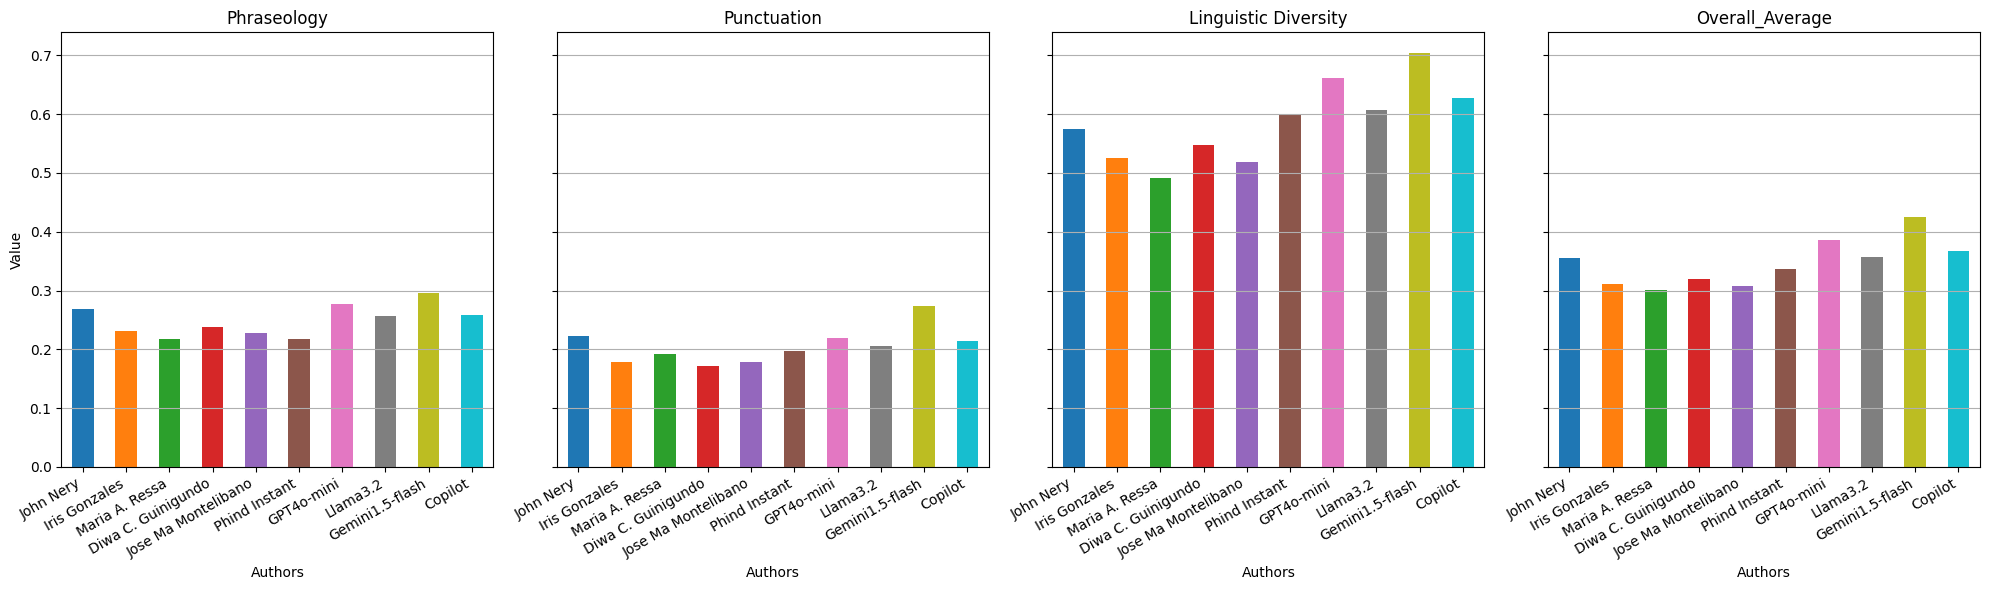

In [22]:
categories = ['Phraseology', 'Punctuation', 'Linguistic Diversity', 'Overall_Average']

unique_authors = author_features_comparisondf["author"].unique()
author_colors = sns.color_palette("tab10", len(unique_authors))  # Use Seaborn's tab10 palette

# Create a color mapping for each author
author_color_map = {author: color for author, color in zip(unique_authors, author_colors)}

# Create subplots for each category
fig, axes = plt.subplots(1, len(categories), figsize=(20, 6), sharey=True)

for i, category in enumerate(categories):
    ax = axes[i]
    
    # Get colors for each author in the same order as the DataFrame
    colors = [author_color_map[author] for author in author_features_comparisondf["author"]]

    # Plot stacked bar chart with per-author colors
    author_features_comparisondf.plot(
        x='author', y=category, kind='bar', stacked=True, ax=ax, legend=False, color=colors
    )
    
    ax.set_title(category)
    ax.set_xlabel("Authors")
    ax.set_ylabel("Value" if i == 0 else "")
    
    # Improve readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right", fontsize=10)
    ax.grid(axis='y', linestyle='-', alpha=1)

# Adjust layout
plt.tight_layout()
plt.show()

In [23]:
df_results = pd.read_csv('main_dataset_test.csv')
df_results

,index,author,text,ai_label,predicted_label_015,predicted_label_020,predicted_label_015_inv,predicted_author,if_pred_author_correct,if_pred_author_is_ai,overall_change_value
0,1,John Nery,The answers she gave in two Senate hearings we...,0,1,1,0,John Nery,1,0,0.2344
1,2,John Nery,Confusing one with the other allows disinforma...,0,1,0,0,John Nery,1,0,0.1619
2,3,John Nery,The complicated but lasting legacy of Benedict...,0,1,1,0,John Nery,1,0,0.2149
3,4,John Nery,Now that she has passed the point of no return...,0,1,0,0,John Nery,1,0,0.1891
4,5,John Nery,The communist insurgency is at its weakest. Co...,0,1,0,0,Diwa C. Guinigundo,0,0,0.1869
...,...,...,...,...,...,...,...,...,...,...,...
45,46,Copilot,The concept of federalism has been a recurring...,1,1,0,0,Copilot,1,1,0.1728
46,47,Copilot,Election campaign finance transparency is a co...,1,1,0,0,Copilot,1,1,0.1501
47,48,Copilot,Mental health stigma remains a significant bar...,1,0,0,1,Copilot,1,1,0.1485
48,49,Copilot,Urban congestion and housing shortages are two...,1,0,0,1,Copilot,1,1,0.1222


In [24]:
# df_results

# Access columns from the DataFrame
ai_label = df_results['ai_label']
predicted_label_015_inv = df_results['predicted_label_015_inv']
predicted_label_020 = df_results['predicted_label_020']
predicted_label_015 = df_results['predicted_label_015']

# #Model Evaluation
accuracy015inv = accuracy_score(ai_label, predicted_label_015_inv) 
print("\nAccuracy Threshold 0.15 Inverse:", accuracy015inv)
accuracy015 = accuracy_score(ai_label, predicted_label_015) 
print("\nAccuracy Threshold 0.15:", accuracy015)
accuracy020 = accuracy_score(ai_label, predicted_label_020) 
print("\nAccuracy Threshold 0.15:", accuracy020)


conf_matrix015inv = confusion_matrix(ai_label, predicted_label_015_inv)
print("\nConfusion Matrix 0.15 Inverse\n", conf_matrix015inv)
conf_matrix015 = confusion_matrix(ai_label, predicted_label_015)
print("\nConfusion Matrix 0.15\n", conf_matrix015)
conf_matrix020 = confusion_matrix(ai_label, predicted_label_020)
print("\nConfusion Matrix 0.20\n", conf_matrix020)



class_report015inv = classification_report(ai_label, predicted_label_015_inv)
print("\nClassification Report 0.15 Inverse:\n", class_report015inv)
class_report015 = classification_report(ai_label, predicted_label_015)
print("\nClassification Report 0.15:\n", class_report015)
class_report020 = classification_report(ai_label, predicted_label_020)
print("\nClassification Report 0.20:\n", class_report020)




Accuracy Threshold 0.15 Inverse: 0.62

Accuracy Threshold 0.15: 0.38

Accuracy Threshold 0.15: 0.5

Confusion Matrix 0.15 Inverse
 [[19  6]
 [13 12]]

Confusion Matrix 0.15
 [[ 6 19]
 [12 13]]

Confusion Matrix 0.20
 [[18  7]
 [18  7]]

Classification Report 0.15 Inverse:
               precision    recall  f1-score   support

           0       0.59      0.76      0.67        25
           1       0.67      0.48      0.56        25

    accuracy                           0.62        50
   macro avg       0.63      0.62      0.61        50
weighted avg       0.63      0.62      0.61        50


Classification Report 0.15:
               precision    recall  f1-score   support

           0       0.33      0.24      0.28        25
           1       0.41      0.52      0.46        25

    accuracy                           0.38        50
   macro avg       0.37      0.38      0.37        50
weighted avg       0.37      0.38      0.37        50


Classification Report 0.20:
            

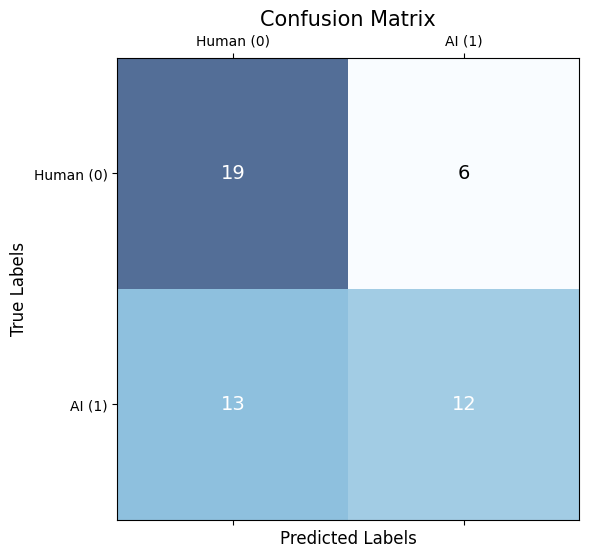

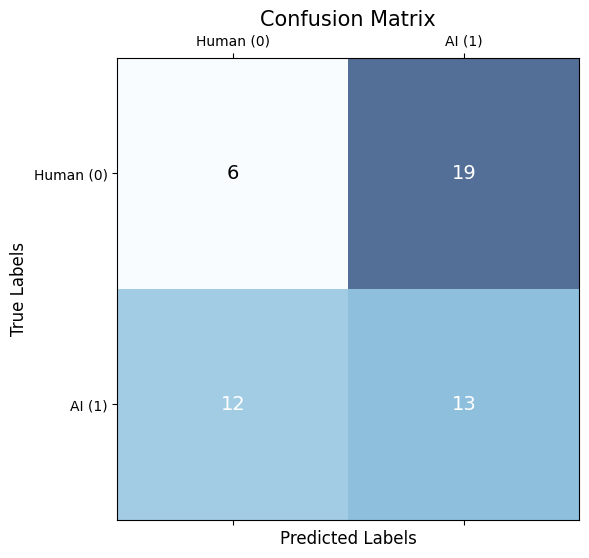

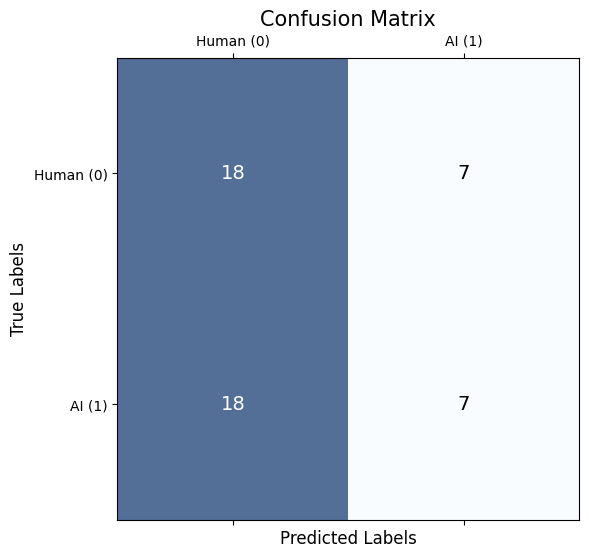

In [25]:
def plot_confusion_matrix(conf_matrix, class_labels):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(conf_matrix, cmap="Blues", alpha=0.7)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(
                x=j, y=i, s=conf_matrix[i, j], 
                va='center', ha='center', 
                fontsize=14, color="black" if conf_matrix[i, j] < np.max(conf_matrix) / 2 else "white"
            )

    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels)
    plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
    plt.title("Confusion Matrix", fontsize=15)
    plt.show()

# Define the class labels
class_labels = ['Human (0)', 'AI (1)']
plot_confusion_matrix(conf_matrix015inv, class_labels)
plot_confusion_matrix(conf_matrix015, class_labels)
plot_confusion_matrix(conf_matrix020, class_labels)